# Estimating The Mortality Rate For COVID-19
> Using Country-Level Covariates To Correct For Testing & Reporting Biases And Estimate a True Mortality Rate.
- author: Joseph Richards
- image: images/corvid-mortality.png
- comments: true
- categories: [MCMC, mortality]
- permalink: /covid-19-mortality-estimation/
- toc: true

In [1]:
#hide
# ! pip install pymc3 arviz xlrd

In [2]:
#hide

# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from IPython.display import display, Markdown

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#hide

# constants

ignore_countries = [
    'Others',
    'Cruise Ship'
]

cpi_country_mapping = {
    'United States of America': 'US',
    'China': 'Mainland China'
}

wb_country_mapping = {
    'United States': 'US',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'China': 'Mainland China',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Korea, Rep.': 'Korea, South'
}

wb_covariates = [
    ('SH.XPD.OOPC.CH.ZS',
        'healthcare_oop_expenditure'),
    ('SH.MED.BEDS.ZS',
        'hospital_beds'),
    ('HD.HCI.OVRL',
        'hci'),
    ('SP.POP.65UP.TO.ZS',
        'population_perc_over65'),
    ('SP.RUR.TOTL.ZS',
        'population_perc_rural')
]

In [4]:
#hide

# data loading and manipulation

from datetime import datetime
import os

import numpy as np
import pandas as pd


def get_all_data():
    '''
    Main routine that grabs all COVID and covariate data and
    returns them as a single dataframe that contains:

    * count of cumulative cases and deaths by country (by today's date)
    * days since first case for each country
    * CPI gov't transparency index
    * World Bank data on population, healthcare, etc. by country
    '''

    all_covid_data = _get_latest_covid_timeseries()

    covid_cases_rollup = _rollup_by_country(all_covid_data['Confirmed'])
    covid_deaths_rollup = _rollup_by_country(all_covid_data['Deaths'])

    todays_date = covid_cases_rollup.columns.max()

    # Create DataFrame with today's cumulative case and death count, by country
    df_out = pd.DataFrame({'cases': covid_cases_rollup[todays_date],
                           'deaths': covid_deaths_rollup[todays_date]})

    _clean_country_list(df_out)
    _clean_country_list(covid_cases_rollup)

    # Add observed death rate:
    df_out['death_rate_observed'] = df_out.apply(
        lambda row: row['deaths'] / float(row['cases']),
        axis=1)

    # Add covariate for days since first case
    df_out['days_since_first_case'] = _compute_days_since_first_case(
        covid_cases_rollup)

    # Add CPI covariate:
    _add_cpi_data(df_out)

    # Add World Bank covariates:
    _add_wb_data(df_out)

    # Drop any country w/o covariate data:
    num_null = df_out.isnull().sum(axis=1)
    to_drop_idx = df_out.index[num_null > 1]
    print('Dropping %i/%i countries due to lack of data' %
          (len(to_drop_idx), len(df_out)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)

    return df_out, todays_date


def _get_latest_covid_timeseries():
    ''' Pull latest time-series data from JHU CSSE database '''

    repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
    data_path = 'csse_covid_19_data/csse_covid_19_time_series/'

    all_data = {}
    for status in ['Confirmed', 'Deaths', 'Recovered']:
        file_name = 'time_series_19-covid-%s.csv' % status
        all_data[status] = pd.read_csv(
            '%s%s%s' % (repo, data_path, file_name))

    return all_data


def _rollup_by_country(df):
    '''
    Roll up each raw time-series by country, adding up the cases
    across the individual states/provinces within the country

    :param df: Pandas DataFrame of raw data from CSSE
    :return: DataFrame of country counts
    '''
    gb = df.groupby('Country/Region')
    df_rollup = gb.sum()
    df_rollup.drop(['Lat', 'Long'], axis=1, inplace=True, errors='ignore')
    
    # Drop dates with all 0 count data
    df_rollup.drop(df_rollup.columns[df_rollup.sum(axis=0) == 0],
                   axis=1,
                   inplace=True)

    # Convert column strings to dates:
    idx_as_dt = [datetime.strptime(x, '%m/%d/%y') for x in df_rollup.columns]
    df_rollup.columns = idx_as_dt
    return df_rollup


def _clean_country_list(df):
    ''' Clean up input country list in df '''
    # handle recent changes in country names:
    country_rename = {
        'Hong Kong SAR': 'Hong Kong',
        'Taiwan*': 'Taiwan',
        'Czechia': 'Czech Republic',
        'Brunei': 'Brunei Darussalam',
        'Iran (Islamic Republic of)': 'Iran',
        'Viet Nam': 'Vietnam',
        'Russian Federation': 'Russia',
        'Republic of Korea': 'South Korea',
        'Republic of Moldova': 'Moldova',
        'China': 'Mainland China'
    }
    df.rename(country_rename, axis=0, inplace=True)
    df.drop(ignore_countries, axis=0, inplace=True, errors='ignore')


def _compute_days_since_first_case(df_cases):
    ''' Compute the country-wise days since first confirmed case

    :param df_cases: country-wise time-series of confirmed case counts
    :return: Series of country-wise days since first case
    '''
    date_first_case = df_cases[df_cases > 0].idxmin(axis=1)
    days_since_first_case = date_first_case.apply(
        lambda x: (df_cases.columns.max() - x).days)
    # Add 1 month for China, since outbreak started late 2019:
    days_since_first_case.loc['Mainland China'] += 30

    return days_since_first_case


def _add_cpi_data(df_input):
    '''
    Add the Government transparency (CPI - corruption perceptions index)
    data (by country) as a column in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add CPI data to df_input in place
    '''
    cpi_data = pd.read_excel(
        'https://github.com/jwrichar/COVID19-mortality/blob/master/data/CPI2019.xlsx?raw=true',
        skiprows=2)
    cpi_data.set_index('Country', inplace=True, drop=True)
    cpi_data.rename(cpi_country_mapping, axis=0, inplace=True)

    # Add CPI score to input df:
    df_input['cpi_score_2019'] = cpi_data['CPI score 2019']


def _add_wb_data(df_input):
    '''
    Add the World Bank data covariates as columns in the COVID cases dataframe.

    :param df_input: COVID-19 data rolled up country-wise
    :return: None, add World Bank data to df_input in place
    '''
    wb_data = pd.read_csv(
        'https://raw.githubusercontent.com/jwrichar/COVID19-mortality/master/data/world_bank_data.csv',
        na_values='..')

    for (wb_name, var_name) in wb_covariates:
        wb_series = wb_data.loc[wb_data['Series Code'] == wb_name]
        wb_series.set_index('Country Name', inplace=True, drop=True)
        wb_series.rename(wb_country_mapping, axis=0, inplace=True)

        # Add WB data:
        df_input[var_name] = _get_most_recent_value(wb_series)


def _get_most_recent_value(wb_series):
    '''
    Get most recent non-null value for each country in the World Bank
    time-series data
    '''
    ts_data = wb_series[wb_series.columns[3::]]

    def _helper(row):
        row_nn = row[row.notnull()]
        if len(row_nn):
            return row_nn[-1]
        else:
            return np.nan

    return ts_data.apply(_helper, axis=1)


In [5]:
#hide

# Load the data (see source/data.py):
df, todays_date = get_all_data()
# Impute NA's column-wise:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

Dropping 19/161 countries due to lack of data


# Observed mortality rates

Data as of 2020-03-20 00:00:00

Overall reported mortality rate: 4.16%

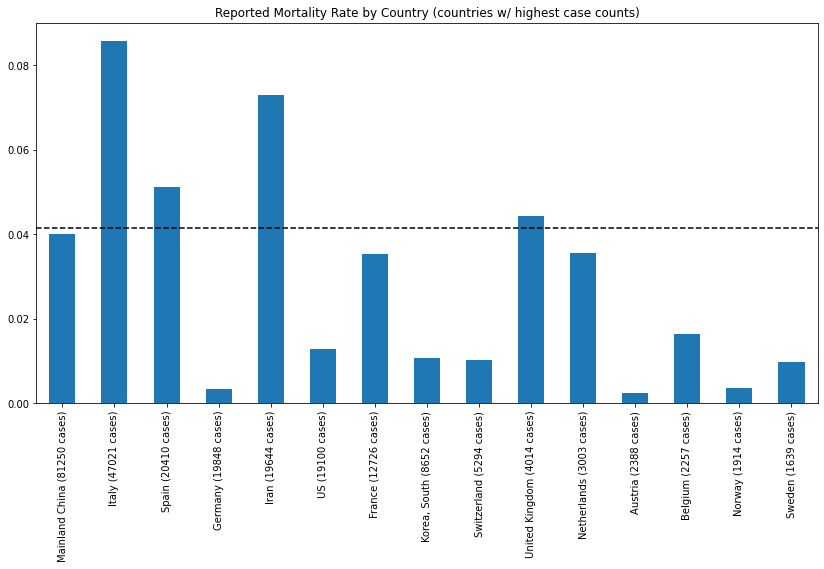

In [6]:
#collapse-hide

display(Markdown('Data as of %s' % todays_date))

reported_mortality_rate = df['deaths'].sum() / df['cases'].sum()
display(Markdown('Overall reported mortality rate: %.2f%%' % (100.0 * reported_mortality_rate)))

df_highest = df.sort_values('cases', ascending=False).head(15)
mortality_rate = pd.Series(
    data=(df_highest['deaths']/df_highest['cases']).values,
    index=map(lambda x: '%s (%i cases)' % (x, df_highest.loc[x]['cases']),
              df_highest.index))
ax = mortality_rate.plot.bar(
    figsize=(14,7), title='Reported Mortality Rate by Country (countries w/ highest case counts)')
ax.axhline(reported_mortality_rate, color='k', ls='--')

plt.show()

# Model

Estimate COVID-19 mortality rate, controling for country factors.

In [7]:
#hide

import numpy as np

import pymc3 as pm


def initialize_model(df):

    # Normalize input covariates in a way that is sensible:

    # (1) days since first case: upper
    # mu_0 to reflect asymptotic mortality rate months after outbreak
    _normalize_col(df, 'days_since_first_case', how='upper')
    # (2) CPI score: upper
    # mu_0 to reflect scenario in absence of corrupt govts
    _normalize_col(df, 'cpi_score_2019', how='upper')
    # (3) healthcare OOP spending: mean
    # not sure which way this will go
    _normalize_col(df, 'healthcare_oop_expenditure', how='mean')
    # (4) hospital beds: upper
    # more beds, more healthcare and tests
    _normalize_col(df, 'hospital_beds', how='mean')
    # (5) hci = human capital index: upper
    # HCI measures education/health; mu_0 should reflect best scenario
    _normalize_col(df, 'hci', how='mean')
    # (6) % over 65: mean
    # mu_0 to reflect average world demographic
    _normalize_col(df, 'population_perc_over65', how='mean')
    # (7) % rural: mean
    # mu_0 to reflect average world demographic
    _normalize_col(df, 'population_perc_rural', how='mean')

    n = len(df)

    covid_mortality_model = pm.Model()

    with covid_mortality_model:

        # Priors:
        mu_0 = pm.Beta('mu_0', alpha=0.3, beta=10)
        sig_0 = pm.Uniform('sig_0', lower=0.0, upper=mu_0 * (1 - mu_0))
        beta = pm.Normal('beta', mu=0, sigma=5, shape=7)
        sigma = pm.HalfNormal('sigma', sigma=5)

        # Model mu from country-wise covariates:
        # Apply logit transformation so logistic regression performed
        mu_0_logit = np.log(mu_0 / (1 - mu_0))
        mu_est = mu_0_logit + \
            beta[0] * df['days_since_first_case_normalized'].values + \
            beta[1] * df['cpi_score_2019_normalized'].values + \
            beta[2] * df['healthcare_oop_expenditure_normalized'].values + \
            beta[3] * df['hospital_beds_normalized'].values + \
            beta[4] * df['hci_normalized'].values + \
            beta[5] * df['population_perc_over65_normalized'].values + \
            beta[6] * df['population_perc_rural_normalized'].values
        mu_model_logit = pm.Normal('mu_model_logit',
                                   mu=mu_est,
                                   sigma=sigma,
                                   shape=n)
        # Transform back to probability space:
        mu_model = np.exp(mu_model_logit) / (np.exp(mu_model_logit) + 1)

        # tau_i, mortality rate for each country
        # Parametrize with (mu, sigma)
        # instead of (alpha, beta) to ease interpretability.
        tau = pm.Beta('tau', mu=mu_model, sigma=sig_0, shape=n)
        # tau = pm.Beta('tau', mu=mu_0, sigma=sig_0, shape=n)

        # Binomial likelihood:
        d_obs = pm.Binomial('d_obs',
                            n=df['cases'].values,
                            p=tau,
                            observed=df['deaths'].values)

    return covid_mortality_model


def _normalize_col(df, colname, how='mean'):
    '''
    Normalize an input column in one of 3 ways:

    * how=mean: unit normal N(0,1)
    * how=upper: normalize to [-1, 0] with highest value set to 0
    * how=lower: normalize to [0, 1] with lowest value set to 0

    Returns df modified in place with extra column added.
    '''
    colname_new = '%s_normalized' % colname
    if how == 'mean':
        mu = df[colname].mean()
        sig = df[colname].std()
        df[colname_new] = (df[colname] - mu) / sig
    elif how == 'upper':
        maxval = df[colname].max()
        minval = df[colname].min()
        df[colname_new] = (df[colname] - maxval) / (maxval - minval)
    elif how == 'lower':
        maxval = df[colname].max()
        minval = df[colname].min()
        df[colname_new] = (df[colname] - minval) / (maxval - minval)

In [8]:
#hide

# Initialize the model:
mod = initialize_model(df)

# Run MCMC sampler1
with mod:
    trace = pm.sample(300, tune=100,
                      chains=3, cores=2)

Only 300 samples in chain.


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (3 chains in 2 jobs)


NUTS: [tau, mu_model_logit, sigma, beta, sig_0, mu_0]


Sampling 3 chains, 0 divergences:   0%|          | 0/1200 [00:00<?, ?draws/s]

Sampling 3 chains, 0 divergences:   1%|          | 11/1200 [00:00<00:16, 72.71draws/s]

Sampling 3 chains, 0 divergences:   1%|          | 14/1200 [00:00<00:30, 39.06draws/s]

Sampling 3 chains, 0 divergences:   1%|▏         | 17/1200 [00:00<00:35, 33.54draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 20/1200 [00:00<00:45, 25.76draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 23/1200 [00:00<00:46, 25.58draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 26/1200 [00:00<00:47, 24.68draws/s]

Sampling 3 chains, 0 divergences:   2%|▏         | 29/1200 [00:01<00:52, 22.43draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 32/1200 [00:01<00:51, 22.89draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 35/1200 [00:01<00:49, 23.64draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 38/1200 [00:01<00:48, 24.10draws/s]

Sampling 3 chains, 0 divergences:   3%|▎         | 41/1200 [00:01<00:50, 23.15draws/s]

Sampling 3 chains, 0 divergences:   4%|▎         | 44/1200 [00:01<00:58, 19.78draws/s]

Sampling 3 chains, 0 divergences:   4%|▍         | 47/1200 [00:01<00:54, 21.18draws/s]

Sampling 3 chains, 0 divergences:   4%|▍         | 50/1200 [00:01<00:51, 22.22draws/s]

Sampling 3 chains, 0 divergences:   4%|▍         | 53/1200 [00:02<00:56, 20.29draws/s]

Sampling 3 chains, 0 divergences:   5%|▍         | 56/1200 [00:02<00:58, 19.46draws/s]

Sampling 3 chains, 0 divergences:   5%|▍         | 59/1200 [00:02<00:56, 20.33draws/s]

Sampling 3 chains, 0 divergences:   5%|▌         | 62/1200 [00:02<00:51, 21.92draws/s]

Sampling 3 chains, 0 divergences:   5%|▌         | 65/1200 [00:02<01:01, 18.49draws/s]

Sampling 3 chains, 0 divergences:   6%|▌         | 67/1200 [00:02<01:02, 18.13draws/s]

Sampling 3 chains, 0 divergences:   6%|▌         | 69/1200 [00:03<01:02, 18.09draws/s]

Sampling 3 chains, 0 divergences:   6%|▌         | 72/1200 [00:03<00:57, 19.47draws/s]

Sampling 3 chains, 0 divergences:   6%|▋         | 75/1200 [00:03<00:52, 21.33draws/s]

Sampling 3 chains, 0 divergences:   6%|▋         | 78/1200 [00:03<00:55, 20.23draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 81/1200 [00:03<00:55, 20.02draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 84/1200 [00:03<01:01, 18.29draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 86/1200 [00:03<01:06, 16.67draws/s]

Sampling 3 chains, 0 divergences:   7%|▋         | 89/1200 [00:04<01:02, 17.89draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 91/1200 [00:04<01:03, 17.34draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 93/1200 [00:04<01:04, 17.13draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 95/1200 [00:04<01:04, 17.22draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 97/1200 [00:04<01:03, 17.35draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 100/1200 [00:04<01:01, 17.90draws/s]

Sampling 3 chains, 0 divergences:   8%|▊         | 102/1200 [00:04<01:01, 17.73draws/s]

Sampling 3 chains, 0 divergences:   9%|▉         | 105/1200 [00:04<00:57, 19.08draws/s]

Sampling 3 chains, 0 divergences:   9%|▉         | 109/1200 [00:05<00:51, 21.29draws/s]

Sampling 3 chains, 0 divergences:   9%|▉         | 112/1200 [00:05<00:52, 20.77draws/s]

Sampling 3 chains, 0 divergences:  10%|▉         | 115/1200 [00:05<00:58, 18.62draws/s]

Sampling 3 chains, 0 divergences:  10%|▉         | 117/1200 [00:05<01:00, 17.86draws/s]

Sampling 3 chains, 0 divergences:  10%|▉         | 119/1200 [00:05<01:01, 17.57draws/s]

Sampling 3 chains, 0 divergences:  10%|█         | 121/1200 [00:05<01:02, 17.26draws/s]

Sampling 3 chains, 0 divergences:  10%|█         | 123/1200 [00:05<01:04, 16.81draws/s]

Sampling 3 chains, 0 divergences:  10%|█         | 126/1200 [00:06<01:01, 17.52draws/s]

Sampling 3 chains, 0 divergences:  11%|█         | 129/1200 [00:06<00:56, 18.85draws/s]

Sampling 3 chains, 0 divergences:  11%|█         | 131/1200 [00:06<00:56, 18.91draws/s]

Sampling 3 chains, 0 divergences:  11%|█         | 133/1200 [00:06<00:57, 18.47draws/s]

Sampling 3 chains, 0 divergences:  11%|█▏        | 136/1200 [00:06<00:52, 20.43draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 139/1200 [00:06<00:51, 20.63draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 142/1200 [00:06<00:52, 20.13draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 145/1200 [00:06<00:53, 19.85draws/s]

Sampling 3 chains, 0 divergences:  12%|█▏        | 148/1200 [00:07<00:49, 21.18draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 151/1200 [00:07<00:58, 17.95draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 153/1200 [00:07<00:58, 17.93draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 155/1200 [00:07<00:58, 17.89draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 157/1200 [00:07<00:59, 17.66draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 159/1200 [00:07<01:00, 17.27draws/s]

Sampling 3 chains, 0 divergences:  13%|█▎        | 161/1200 [00:07<01:00, 17.26draws/s]

Sampling 3 chains, 0 divergences:  14%|█▎        | 164/1200 [00:08<00:55, 18.76draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 166/1200 [00:08<00:56, 18.45draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 168/1200 [00:08<00:57, 18.05draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 170/1200 [00:08<00:57, 17.76draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 172/1200 [00:08<00:58, 17.70draws/s]

Sampling 3 chains, 0 divergences:  14%|█▍        | 174/1200 [00:08<00:58, 17.61draws/s]

Sampling 3 chains, 0 divergences:  15%|█▍        | 176/1200 [00:08<00:58, 17.41draws/s]

Sampling 3 chains, 0 divergences:  15%|█▍        | 178/1200 [00:08<00:58, 17.58draws/s]

Sampling 3 chains, 0 divergences:  15%|█▌        | 180/1200 [00:08<00:57, 17.66draws/s]

Sampling 3 chains, 0 divergences:  15%|█▌        | 182/1200 [00:09<00:57, 17.56draws/s]

Sampling 3 chains, 0 divergences:  15%|█▌        | 184/1200 [00:09<00:58, 17.52draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 186/1200 [00:09<00:57, 17.52draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 188/1200 [00:09<00:56, 17.96draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 190/1200 [00:09<00:58, 17.23draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 192/1200 [00:09<00:59, 16.93draws/s]

Sampling 3 chains, 0 divergences:  16%|█▌        | 194/1200 [00:09<00:59, 17.02draws/s]

Sampling 3 chains, 0 divergences:  16%|█▋        | 197/1200 [00:09<00:53, 18.60draws/s]

Sampling 3 chains, 0 divergences:  17%|█▋        | 199/1200 [00:10<00:57, 17.48draws/s]

Sampling 3 chains, 0 divergences:  17%|█▋        | 201/1200 [00:10<00:57, 17.33draws/s]

Sampling 3 chains, 0 divergences:  17%|█▋        | 203/1200 [00:10<00:59, 16.88draws/s]

Sampling 3 chains, 1 divergences:  17%|█▋        | 204/1200 [00:10<00:59, 16.88draws/s]

Sampling 3 chains, 1 divergences:  17%|█▋        | 205/1200 [00:10<00:56, 17.66draws/s]

Sampling 3 chains, 2 divergences:  17%|█▋        | 206/1200 [00:10<00:56, 17.66draws/s]

Sampling 3 chains, 2 divergences:  17%|█▋        | 207/1200 [00:10<00:55, 18.04draws/s]

Sampling 3 chains, 2 divergences:  17%|█▋        | 209/1200 [00:10<00:55, 17.89draws/s]

Sampling 3 chains, 3 divergences:  17%|█▋        | 209/1200 [00:10<00:55, 17.89draws/s]

Sampling 3 chains, 3 divergences:  18%|█▊        | 211/1200 [00:10<00:57, 17.13draws/s]

Sampling 3 chains, 4 divergences:  18%|█▊        | 211/1200 [00:10<00:57, 17.13draws/s]

Sampling 3 chains, 4 divergences:  18%|█▊        | 213/1200 [00:10<00:57, 17.10draws/s]

Sampling 3 chains, 4 divergences:  18%|█▊        | 215/1200 [00:10<01:04, 15.17draws/s]

Sampling 3 chains, 5 divergences:  18%|█▊        | 216/1200 [00:11<01:04, 15.17draws/s]

Sampling 3 chains, 6 divergences:  18%|█▊        | 217/1200 [00:11<01:04, 15.17draws/s]

Sampling 3 chains, 6 divergences:  18%|█▊        | 218/1200 [00:11<00:56, 17.28draws/s]

Sampling 3 chains, 6 divergences:  18%|█▊        | 220/1200 [00:11<01:06, 14.66draws/s]

Sampling 3 chains, 7 divergences:  18%|█▊        | 221/1200 [00:11<01:06, 14.66draws/s]

Sampling 3 chains, 7 divergences:  19%|█▊        | 223/1200 [00:11<01:07, 14.52draws/s]

Sampling 3 chains, 7 divergences:  19%|█▉        | 225/1200 [00:11<01:03, 15.44draws/s]

Sampling 3 chains, 7 divergences:  19%|█▉        | 227/1200 [00:11<01:05, 14.82draws/s]

Sampling 3 chains, 8 divergences:  19%|█▉        | 227/1200 [00:11<01:05, 14.82draws/s]

Sampling 3 chains, 8 divergences:  19%|█▉        | 229/1200 [00:11<01:05, 14.81draws/s]

Sampling 3 chains, 8 divergences:  19%|█▉        | 231/1200 [00:11<01:02, 15.53draws/s]

Sampling 3 chains, 8 divergences:  19%|█▉        | 233/1200 [00:12<01:15, 12.85draws/s]

Sampling 3 chains, 8 divergences:  20%|█▉        | 235/1200 [00:12<01:11, 13.53draws/s]

Sampling 3 chains, 9 divergences:  20%|█▉        | 235/1200 [00:12<01:11, 13.53draws/s]

Sampling 3 chains, 10 divergences:  20%|█▉        | 236/1200 [00:12<01:11, 13.53draws/s]

Sampling 3 chains, 10 divergences:  20%|█▉        | 238/1200 [00:12<00:59, 16.16draws/s]

Sampling 3 chains, 10 divergences:  20%|██        | 240/1200 [00:12<01:12, 13.25draws/s]

Sampling 3 chains, 10 divergences:  20%|██        | 242/1200 [00:12<01:07, 14.16draws/s]

Sampling 3 chains, 10 divergences:  20%|██        | 244/1200 [00:12<01:06, 14.29draws/s]

Sampling 3 chains, 11 divergences:  20%|██        | 244/1200 [00:13<01:06, 14.29draws/s]

Sampling 3 chains, 11 divergences:  20%|██        | 246/1200 [00:13<01:04, 14.89draws/s]

Sampling 3 chains, 12 divergences:  21%|██        | 247/1200 [00:13<01:04, 14.89draws/s]

Sampling 3 chains, 12 divergences:  21%|██        | 248/1200 [00:13<01:06, 14.39draws/s]

Sampling 3 chains, 13 divergences:  21%|██        | 248/1200 [00:13<01:06, 14.39draws/s]

Sampling 3 chains, 13 divergences:  21%|██        | 251/1200 [00:13<01:05, 14.60draws/s]

Sampling 3 chains, 13 divergences:  21%|██        | 253/1200 [00:13<01:09, 13.62draws/s]

Sampling 3 chains, 14 divergences:  21%|██        | 253/1200 [00:13<01:09, 13.62draws/s]

Sampling 3 chains, 15 divergences:  21%|██        | 254/1200 [00:13<01:09, 13.62draws/s]

Sampling 3 chains, 15 divergences:  21%|██▏       | 256/1200 [00:13<01:07, 13.89draws/s]

Sampling 3 chains, 15 divergences:  22%|██▏       | 258/1200 [00:13<01:04, 14.59draws/s]

Sampling 3 chains, 16 divergences:  22%|██▏       | 258/1200 [00:13<01:04, 14.59draws/s]

Sampling 3 chains, 17 divergences:  22%|██▏       | 259/1200 [00:14<01:04, 14.59draws/s]

Sampling 3 chains, 17 divergences:  22%|██▏       | 260/1200 [00:14<01:03, 14.75draws/s]

Sampling 3 chains, 18 divergences:  22%|██▏       | 261/1200 [00:14<01:03, 14.75draws/s]

Sampling 3 chains, 19 divergences:  22%|██▏       | 262/1200 [00:14<01:03, 14.75draws/s]

Sampling 3 chains, 20 divergences:  22%|██▏       | 263/1200 [00:14<01:03, 14.75draws/s]

Sampling 3 chains, 20 divergences:  22%|██▏       | 264/1200 [00:14<00:51, 18.01draws/s]

Sampling 3 chains, 21 divergences:  22%|██▏       | 264/1200 [00:14<00:51, 18.01draws/s]

Sampling 3 chains, 22 divergences:  22%|██▏       | 265/1200 [00:14<00:51, 18.01draws/s]

Sampling 3 chains, 23 divergences:  22%|██▏       | 266/1200 [00:14<00:51, 18.01draws/s]

Sampling 3 chains, 24 divergences:  22%|██▏       | 267/1200 [00:14<00:51, 18.01draws/s]

Sampling 3 chains, 24 divergences:  22%|██▏       | 268/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 25 divergences:  22%|██▏       | 268/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 26 divergences:  22%|██▏       | 269/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 27 divergences:  22%|██▎       | 270/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 28 divergences:  23%|██▎       | 271/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 29 divergences:  23%|██▎       | 272/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 30 divergences:  23%|██▎       | 275/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 31 divergences:  23%|██▎       | 276/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 32 divergences:  23%|██▎       | 277/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 33 divergences:  23%|██▎       | 278/1200 [00:14<00:43, 21.40draws/s]

Sampling 3 chains, 33 divergences:  23%|██▎       | 279/1200 [00:14<00:34, 26.72draws/s]

Sampling 3 chains, 34 divergences:  23%|██▎       | 280/1200 [00:14<00:34, 26.72draws/s]

Sampling 3 chains, 35 divergences:  23%|██▎       | 281/1200 [00:14<00:34, 26.72draws/s]

Sampling 3 chains, 36 divergences:  24%|██▎       | 282/1200 [00:14<00:34, 26.72draws/s]

Sampling 3 chains, 37 divergences:  24%|██▎       | 283/1200 [00:14<00:34, 26.72draws/s]

Sampling 3 chains, 38 divergences:  24%|██▎       | 284/1200 [00:14<00:34, 26.72draws/s]

Sampling 3 chains, 39 divergences:  24%|██▍       | 285/1200 [00:14<00:34, 26.72draws/s]

Sampling 3 chains, 39 divergences:  24%|██▍       | 286/1200 [00:14<00:27, 32.72draws/s]

Sampling 3 chains, 40 divergences:  24%|██▍       | 286/1200 [00:14<00:27, 32.72draws/s]

Sampling 3 chains, 41 divergences:  24%|██▍       | 287/1200 [00:14<00:27, 32.72draws/s]

Sampling 3 chains, 42 divergences:  24%|██▍       | 288/1200 [00:14<00:27, 32.72draws/s]

Sampling 3 chains, 43 divergences:  24%|██▍       | 290/1200 [00:14<00:27, 32.72draws/s]

Sampling 3 chains, 43 divergences:  24%|██▍       | 291/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 44 divergences:  24%|██▍       | 291/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 45 divergences:  24%|██▍       | 292/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 46 divergences:  24%|██▍       | 293/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 47 divergences:  25%|██▍       | 295/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 48 divergences:  25%|██▍       | 296/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 49 divergences:  25%|██▍       | 297/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 50 divergences:  25%|██▍       | 298/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 51 divergences:  25%|██▍       | 299/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 52 divergences:  25%|██▌       | 300/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 53 divergences:  25%|██▌       | 301/1200 [00:14<00:25, 35.67draws/s]

Sampling 3 chains, 53 divergences:  25%|██▌       | 302/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 54 divergences:  25%|██▌       | 302/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 55 divergences:  25%|██▌       | 303/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 56 divergences:  25%|██▌       | 304/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 57 divergences:  25%|██▌       | 305/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 58 divergences:  26%|██▌       | 306/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 59 divergences:  26%|██▌       | 307/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 60 divergences:  26%|██▌       | 308/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 61 divergences:  26%|██▌       | 309/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 62 divergences:  26%|██▌       | 310/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 63 divergences:  26%|██▌       | 311/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 64 divergences:  26%|██▌       | 312/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 65 divergences:  26%|██▌       | 313/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 66 divergences:  26%|██▌       | 314/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 67 divergences:  26%|██▋       | 315/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 68 divergences:  26%|██▋       | 316/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 69 divergences:  26%|██▋       | 317/1200 [00:14<00:20, 43.49draws/s]

Sampling 3 chains, 69 divergences:  26%|██▋       | 318/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 70 divergences:  26%|██▋       | 318/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 71 divergences:  27%|██▋       | 319/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 72 divergences:  27%|██▋       | 320/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 73 divergences:  27%|██▋       | 321/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 74 divergences:  27%|██▋       | 322/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 75 divergences:  27%|██▋       | 323/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 76 divergences:  27%|██▋       | 324/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 77 divergences:  27%|██▋       | 325/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 78 divergences:  27%|██▋       | 326/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 79 divergences:  27%|██▋       | 328/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 80 divergences:  27%|██▋       | 329/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 81 divergences:  28%|██▊       | 330/1200 [00:14<00:15, 55.39draws/s]

Sampling 3 chains, 81 divergences:  28%|██▊       | 331/1200 [00:14<00:13, 66.81draws/s]

Sampling 3 chains, 82 divergences:  28%|██▊       | 331/1200 [00:14<00:13, 66.81draws/s]

Sampling 3 chains, 83 divergences:  28%|██▊       | 332/1200 [00:14<00:12, 66.81draws/s]

Sampling 3 chains, 84 divergences:  28%|██▊       | 333/1200 [00:14<00:12, 66.81draws/s]

Sampling 3 chains, 85 divergences:  28%|██▊       | 334/1200 [00:14<00:12, 66.81draws/s]

Sampling 3 chains, 86 divergences:  28%|██▊       | 335/1200 [00:15<00:12, 66.81draws/s]

Sampling 3 chains, 87 divergences:  28%|██▊       | 336/1200 [00:15<00:12, 66.81draws/s]

Sampling 3 chains, 88 divergences:  28%|██▊       | 337/1200 [00:15<00:12, 66.81draws/s]

Sampling 3 chains, 89 divergences:  28%|██▊       | 338/1200 [00:15<00:12, 66.81draws/s]

Sampling 3 chains, 90 divergences:  28%|██▊       | 339/1200 [00:15<00:12, 66.81draws/s]

Sampling 3 chains, 91 divergences:  28%|██▊       | 340/1200 [00:15<00:12, 66.81draws/s]

Sampling 3 chains, 92 divergences:  28%|██▊       | 341/1200 [00:15<00:12, 66.81draws/s]

Sampling 3 chains, 93 divergences:  28%|██▊       | 342/1200 [00:15<00:12, 66.81draws/s]

Sampling 3 chains, 93 divergences:  29%|██▊       | 343/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 94 divergences:  29%|██▊       | 343/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 95 divergences:  29%|██▊       | 344/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 96 divergences:  29%|██▉       | 345/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 97 divergences:  29%|██▉       | 346/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 98 divergences:  29%|██▉       | 347/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 99 divergences:  29%|██▉       | 348/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 100 divergences:  29%|██▉       | 349/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 101 divergences:  29%|██▉       | 350/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 102 divergences:  29%|██▉       | 351/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 103 divergences:  29%|██▉       | 352/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 104 divergences:  29%|██▉       | 353/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 105 divergences:  30%|██▉       | 354/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 106 divergences:  30%|██▉       | 355/1200 [00:15<00:11, 75.70draws/s]

Sampling 3 chains, 106 divergences:  30%|██▉       | 356/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 107 divergences:  30%|██▉       | 356/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 108 divergences:  30%|██▉       | 357/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 109 divergences:  30%|██▉       | 358/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 110 divergences:  30%|██▉       | 359/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 111 divergences:  30%|███       | 360/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 112 divergences:  30%|███       | 361/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 113 divergences:  30%|███       | 362/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 114 divergences:  30%|███       | 363/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 115 divergences:  30%|███       | 364/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 116 divergences:  30%|███       | 365/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 117 divergences:  30%|███       | 366/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 118 divergences:  31%|███       | 367/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 119 divergences:  31%|███       | 368/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 120 divergences:  31%|███       | 369/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 121 divergences:  31%|███       | 370/1200 [00:15<00:09, 85.20draws/s]

Sampling 3 chains, 121 divergences:  31%|███       | 371/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 122 divergences:  31%|███       | 371/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 123 divergences:  31%|███       | 372/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 124 divergences:  31%|███       | 373/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 125 divergences:  31%|███       | 374/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 126 divergences:  31%|███▏      | 375/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 127 divergences:  31%|███▏      | 376/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 128 divergences:  31%|███▏      | 377/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 129 divergences:  32%|███▏      | 378/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 130 divergences:  32%|███▏      | 379/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 131 divergences:  32%|███▏      | 380/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 132 divergences:  32%|███▏      | 381/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 133 divergences:  32%|███▏      | 382/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 134 divergences:  32%|███▏      | 383/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 135 divergences:  32%|███▏      | 384/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 136 divergences:  32%|███▏      | 385/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 137 divergences:  32%|███▏      | 386/1200 [00:15<00:08, 95.77draws/s]

Sampling 3 chains, 137 divergences:  32%|███▏      | 387/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 138 divergences:  32%|███▏      | 387/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 139 divergences:  32%|███▏      | 388/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 140 divergences:  32%|███▏      | 389/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 141 divergences:  32%|███▎      | 390/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 142 divergences:  33%|███▎      | 391/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 143 divergences:  33%|███▎      | 392/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 144 divergences:  33%|███▎      | 393/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 145 divergences:  33%|███▎      | 394/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 146 divergences:  33%|███▎      | 395/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 147 divergences:  33%|███▎      | 396/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 148 divergences:  33%|███▎      | 397/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 149 divergences:  33%|███▎      | 398/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 150 divergences:  33%|███▎      | 399/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 151 divergences:  33%|███▎      | 400/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 152 divergences:  33%|███▎      | 401/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 153 divergences:  34%|███▎      | 402/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 154 divergences:  34%|███▎      | 403/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 155 divergences:  34%|███▎      | 404/1200 [00:15<00:07, 107.63draws/s]

Sampling 3 chains, 155 divergences:  34%|███▍      | 405/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 156 divergences:  34%|███▍      | 405/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 157 divergences:  34%|███▍      | 406/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 158 divergences:  34%|███▍      | 407/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 159 divergences:  34%|███▍      | 408/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 160 divergences:  34%|███▍      | 409/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 161 divergences:  34%|███▍      | 410/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 162 divergences:  34%|███▍      | 411/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 163 divergences:  34%|███▍      | 412/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 164 divergences:  34%|███▍      | 413/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 165 divergences:  34%|███▍      | 414/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 166 divergences:  35%|███▍      | 415/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 167 divergences:  35%|███▍      | 416/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 168 divergences:  35%|███▍      | 417/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 169 divergences:  35%|███▍      | 418/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 170 divergences:  35%|███▍      | 419/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 171 divergences:  35%|███▌      | 420/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 172 divergences:  35%|███▌      | 421/1200 [00:15<00:06, 120.59draws/s]

Sampling 3 chains, 172 divergences:  35%|███▌      | 422/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 173 divergences:  35%|███▌      | 422/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 174 divergences:  35%|███▌      | 423/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 175 divergences:  35%|███▌      | 424/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 176 divergences:  35%|███▌      | 425/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 177 divergences:  36%|███▌      | 426/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 178 divergences:  36%|███▌      | 427/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 179 divergences:  36%|███▌      | 428/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 180 divergences:  36%|███▌      | 429/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 181 divergences:  36%|███▌      | 430/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 182 divergences:  36%|███▌      | 431/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 183 divergences:  36%|███▌      | 432/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 184 divergences:  36%|███▌      | 433/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 185 divergences:  36%|███▋      | 435/1200 [00:15<00:05, 131.36draws/s]

Sampling 3 chains, 185 divergences:  36%|███▋      | 437/1200 [00:15<00:08, 94.09draws/s] 

Sampling 3 chains, 186 divergences:  36%|███▋      | 437/1200 [00:15<00:08, 94.09draws/s]

Sampling 3 chains, 187 divergences:  36%|███▋      | 438/1200 [00:16<00:08, 94.09draws/s]

Sampling 3 chains, 188 divergences:  37%|███▋      | 439/1200 [00:16<00:08, 94.09draws/s]

Sampling 3 chains, 189 divergences:  37%|███▋      | 441/1200 [00:16<00:08, 94.09draws/s]

Sampling 3 chains, 190 divergences:  37%|███▋      | 448/1200 [00:16<00:07, 94.09draws/s]

Sampling 3 chains, 190 divergences:  37%|███▋      | 449/1200 [00:16<00:19, 38.83draws/s]

Sampling 3 chains, 191 divergences:  37%|███▋      | 449/1200 [00:16<00:19, 38.83draws/s]

Sampling 3 chains, 192 divergences:  38%|███▊      | 453/1200 [00:17<00:19, 38.83draws/s]

Sampling 3 chains, 193 divergences:  38%|███▊      | 456/1200 [00:17<00:19, 38.83draws/s]

Sampling 3 chains, 193 divergences:  38%|███▊      | 458/1200 [00:17<00:29, 25.21draws/s]

Sampling 3 chains, 194 divergences:  38%|███▊      | 458/1200 [00:17<00:29, 25.21draws/s]

Sampling 3 chains, 195 divergences:  38%|███▊      | 459/1200 [00:17<00:29, 25.21draws/s]

Sampling 3 chains, 196 divergences:  38%|███▊      | 460/1200 [00:17<00:29, 25.21draws/s]

Sampling 3 chains, 197 divergences:  38%|███▊      | 461/1200 [00:17<00:29, 25.21draws/s]

Sampling 3 chains, 198 divergences:  38%|███▊      | 462/1200 [00:17<00:29, 25.21draws/s]

Sampling 3 chains, 199 divergences:  39%|███▊      | 464/1200 [00:17<00:29, 25.21draws/s]

Sampling 3 chains, 199 divergences:  39%|███▉      | 465/1200 [00:17<00:34, 21.24draws/s]

Sampling 3 chains, 200 divergences:  39%|███▉      | 466/1200 [00:17<00:34, 21.24draws/s]

Sampling 3 chains, 201 divergences:  39%|███▉      | 468/1200 [00:17<00:34, 21.24draws/s]

Sampling 3 chains, 202 divergences:  39%|███▉      | 470/1200 [00:18<00:34, 21.24draws/s]

Sampling 3 chains, 202 divergences:  39%|███▉      | 471/1200 [00:18<00:39, 18.65draws/s]

Sampling 3 chains, 203 divergences:  39%|███▉      | 473/1200 [00:18<00:38, 18.65draws/s]

Sampling 3 chains, 204 divergences:  40%|███▉      | 474/1200 [00:18<00:38, 18.65draws/s]

Sampling 3 chains, 205 divergences:  40%|███▉      | 475/1200 [00:18<00:38, 18.65draws/s]

Sampling 3 chains, 205 divergences:  40%|███▉      | 476/1200 [00:18<00:37, 19.56draws/s]

Sampling 3 chains, 206 divergences:  40%|███▉      | 476/1200 [00:18<00:37, 19.56draws/s]

Sampling 3 chains, 207 divergences:  40%|███▉      | 477/1200 [00:18<00:36, 19.56draws/s]

Sampling 3 chains, 208 divergences:  40%|███▉      | 478/1200 [00:18<00:36, 19.56draws/s]

Sampling 3 chains, 208 divergences:  40%|████      | 480/1200 [00:18<00:35, 20.48draws/s]

Sampling 3 chains, 209 divergences:  40%|████      | 483/1200 [00:18<00:35, 20.48draws/s]

Sampling 3 chains, 209 divergences:  40%|████      | 484/1200 [00:18<00:42, 16.90draws/s]

Sampling 3 chains, 210 divergences:  40%|████      | 485/1200 [00:18<00:42, 16.90draws/s]

Sampling 3 chains, 211 divergences:  40%|████      | 486/1200 [00:18<00:42, 16.90draws/s]

Sampling 3 chains, 211 divergences:  41%|████      | 487/1200 [00:18<00:39, 18.03draws/s]

Sampling 3 chains, 212 divergences:  41%|████      | 488/1200 [00:19<00:39, 18.03draws/s]

Sampling 3 chains, 213 divergences:  41%|████      | 489/1200 [00:19<00:39, 18.03draws/s]

Sampling 3 chains, 213 divergences:  41%|████      | 490/1200 [00:19<00:37, 18.87draws/s]

Sampling 3 chains, 214 divergences:  41%|████      | 490/1200 [00:19<00:37, 18.87draws/s]

Sampling 3 chains, 215 divergences:  41%|████      | 491/1200 [00:19<00:37, 18.87draws/s]

Sampling 3 chains, 216 divergences:  41%|████      | 492/1200 [00:19<00:37, 18.87draws/s]

Sampling 3 chains, 217 divergences:  41%|████      | 493/1200 [00:19<00:37, 18.87draws/s]

Sampling 3 chains, 218 divergences:  41%|████      | 494/1200 [00:19<00:37, 18.87draws/s]

Sampling 3 chains, 219 divergences:  41%|████▏     | 495/1200 [00:19<00:37, 18.87draws/s]

Sampling 3 chains, 219 divergences:  41%|████▏     | 496/1200 [00:19<00:30, 23.31draws/s]

Sampling 3 chains, 220 divergences:  41%|████▏     | 496/1200 [00:19<00:30, 23.31draws/s]

Sampling 3 chains, 221 divergences:  41%|████▏     | 497/1200 [00:19<00:30, 23.31draws/s]

Sampling 3 chains, 222 divergences:  42%|████▏     | 498/1200 [00:19<00:30, 23.31draws/s]

Sampling 3 chains, 223 divergences:  42%|████▏     | 499/1200 [00:19<00:30, 23.31draws/s]

Sampling 3 chains, 223 divergences:  42%|████▏     | 500/1200 [00:19<00:26, 26.33draws/s]

Sampling 3 chains, 224 divergences:  42%|████▏     | 500/1200 [00:19<00:26, 26.33draws/s]

Sampling 3 chains, 225 divergences:  42%|████▏     | 501/1200 [00:19<00:26, 26.33draws/s]

Sampling 3 chains, 226 divergences:  42%|████▏     | 503/1200 [00:19<00:26, 26.33draws/s]

Sampling 3 chains, 226 divergences:  42%|████▏     | 504/1200 [00:19<00:25, 27.82draws/s]

Sampling 3 chains, 227 divergences:  42%|████▏     | 504/1200 [00:19<00:25, 27.82draws/s]

Sampling 3 chains, 228 divergences:  42%|████▏     | 505/1200 [00:19<00:24, 27.82draws/s]

Sampling 3 chains, 229 divergences:  42%|████▏     | 506/1200 [00:19<00:24, 27.82draws/s]

Sampling 3 chains, 230 divergences:  42%|████▏     | 507/1200 [00:19<00:24, 27.82draws/s]

Sampling 3 chains, 230 divergences:  42%|████▏     | 508/1200 [00:19<00:22, 30.38draws/s]

Sampling 3 chains, 231 divergences:  42%|████▏     | 508/1200 [00:19<00:22, 30.38draws/s]

Sampling 3 chains, 232 divergences:  42%|████▏     | 509/1200 [00:19<00:22, 30.38draws/s]

Sampling 3 chains, 233 divergences:  42%|████▎     | 510/1200 [00:19<00:22, 30.38draws/s]

Sampling 3 chains, 234 divergences:  43%|████▎     | 511/1200 [00:19<00:22, 30.38draws/s]

Sampling 3 chains, 235 divergences:  43%|████▎     | 512/1200 [00:19<00:22, 30.38draws/s]

Sampling 3 chains, 236 divergences:  43%|████▎     | 513/1200 [00:19<00:22, 30.38draws/s]

Sampling 3 chains, 237 divergences:  43%|████▎     | 514/1200 [00:19<00:22, 30.38draws/s]

Sampling 3 chains, 237 divergences:  43%|████▎     | 515/1200 [00:19<00:19, 34.82draws/s]

Sampling 3 chains, 238 divergences:  43%|████▎     | 515/1200 [00:19<00:19, 34.82draws/s]

Sampling 3 chains, 239 divergences:  43%|████▎     | 516/1200 [00:19<00:19, 34.82draws/s]

Sampling 3 chains, 240 divergences:  43%|████▎     | 517/1200 [00:19<00:19, 34.82draws/s]

Sampling 3 chains, 241 divergences:  43%|████▎     | 518/1200 [00:19<00:19, 34.82draws/s]

Sampling 3 chains, 242 divergences:  43%|████▎     | 519/1200 [00:19<00:19, 34.82draws/s]

Sampling 3 chains, 242 divergences:  43%|████▎     | 520/1200 [00:19<00:17, 38.15draws/s]

Sampling 3 chains, 243 divergences:  43%|████▎     | 520/1200 [00:19<00:17, 38.15draws/s]

Sampling 3 chains, 244 divergences:  43%|████▎     | 521/1200 [00:19<00:17, 38.15draws/s]

Sampling 3 chains, 245 divergences:  44%|████▎     | 522/1200 [00:19<00:17, 38.15draws/s]

Sampling 3 chains, 246 divergences:  44%|████▎     | 523/1200 [00:19<00:17, 38.15draws/s]

Sampling 3 chains, 247 divergences:  44%|████▎     | 524/1200 [00:19<00:17, 38.15draws/s]

Sampling 3 chains, 247 divergences:  44%|████▍     | 525/1200 [00:19<00:16, 40.70draws/s]

Sampling 3 chains, 248 divergences:  44%|████▍     | 525/1200 [00:19<00:16, 40.70draws/s]

Sampling 3 chains, 249 divergences:  44%|████▍     | 526/1200 [00:19<00:16, 40.70draws/s]

Sampling 3 chains, 250 divergences:  44%|████▍     | 527/1200 [00:19<00:16, 40.70draws/s]

Sampling 3 chains, 251 divergences:  44%|████▍     | 528/1200 [00:20<00:16, 40.70draws/s]

Sampling 3 chains, 252 divergences:  44%|████▍     | 529/1200 [00:20<00:16, 40.70draws/s]

Sampling 3 chains, 252 divergences:  44%|████▍     | 530/1200 [00:20<00:16, 41.73draws/s]

Sampling 3 chains, 253 divergences:  44%|████▍     | 530/1200 [00:20<00:16, 41.73draws/s]

Sampling 3 chains, 254 divergences:  44%|████▍     | 531/1200 [00:20<00:16, 41.73draws/s]

Sampling 3 chains, 255 divergences:  44%|████▍     | 532/1200 [00:20<00:16, 41.73draws/s]

Sampling 3 chains, 256 divergences:  44%|████▍     | 533/1200 [00:20<00:15, 41.73draws/s]

Sampling 3 chains, 256 divergences:  45%|████▍     | 535/1200 [00:20<00:15, 43.08draws/s]

Sampling 3 chains, 257 divergences:  45%|████▍     | 536/1200 [00:20<00:15, 43.08draws/s]

Sampling 3 chains, 258 divergences:  45%|████▍     | 537/1200 [00:20<00:15, 43.08draws/s]

Sampling 3 chains, 259 divergences:  45%|████▍     | 538/1200 [00:20<00:15, 43.08draws/s]

Sampling 3 chains, 259 divergences:  45%|████▌     | 540/1200 [00:20<00:19, 34.04draws/s]

Sampling 3 chains, 260 divergences:  45%|████▌     | 540/1200 [00:20<00:19, 34.04draws/s]

Sampling 3 chains, 261 divergences:  45%|████▌     | 541/1200 [00:20<00:19, 34.04draws/s]

Sampling 3 chains, 262 divergences:  45%|████▌     | 542/1200 [00:20<00:19, 34.04draws/s]

Sampling 3 chains, 263 divergences:  45%|████▌     | 543/1200 [00:20<00:19, 34.04draws/s]

Sampling 3 chains, 263 divergences:  45%|████▌     | 544/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 264 divergences:  45%|████▌     | 544/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 265 divergences:  45%|████▌     | 545/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 266 divergences:  46%|████▌     | 546/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 267 divergences:  46%|████▌     | 547/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 268 divergences:  46%|████▌     | 548/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 269 divergences:  46%|████▌     | 549/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 270 divergences:  46%|████▌     | 550/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 271 divergences:  46%|████▌     | 551/1200 [00:20<00:18, 35.59draws/s]

Sampling 3 chains, 271 divergences:  46%|████▌     | 552/1200 [00:20<00:15, 41.64draws/s]

Sampling 3 chains, 272 divergences:  46%|████▌     | 552/1200 [00:20<00:15, 41.64draws/s]

Sampling 3 chains, 273 divergences:  46%|████▌     | 553/1200 [00:20<00:15, 41.64draws/s]

Sampling 3 chains, 274 divergences:  46%|████▌     | 554/1200 [00:20<00:15, 41.64draws/s]

Sampling 3 chains, 275 divergences:  46%|████▋     | 555/1200 [00:20<00:15, 41.64draws/s]

Sampling 3 chains, 276 divergences:  46%|████▋     | 556/1200 [00:20<00:15, 41.64draws/s]

Sampling 3 chains, 277 divergences:  46%|████▋     | 557/1200 [00:20<00:15, 41.64draws/s]

Sampling 3 chains, 278 divergences:  46%|████▋     | 558/1200 [00:20<00:15, 41.64draws/s]

Sampling 3 chains, 278 divergences:  47%|████▋     | 559/1200 [00:20<00:14, 45.15draws/s]

Sampling 3 chains, 279 divergences:  47%|████▋     | 559/1200 [00:20<00:14, 45.15draws/s]

Sampling 3 chains, 279 divergences:  48%|████▊     | 570/1200 [00:20<00:12, 50.79draws/s]

Sampling 3 chains, 280 divergences:  48%|████▊     | 572/1200 [00:20<00:12, 50.79draws/s]

Sampling 3 chains, 281 divergences:  48%|████▊     | 573/1200 [00:20<00:12, 50.79draws/s]

Sampling 3 chains, 282 divergences:  48%|████▊     | 574/1200 [00:20<00:12, 50.79draws/s]

Sampling 3 chains, 282 divergences:  48%|████▊     | 576/1200 [00:21<00:13, 44.66draws/s]

Sampling 3 chains, 283 divergences:  48%|████▊     | 576/1200 [00:21<00:13, 44.66draws/s]

Sampling 3 chains, 284 divergences:  48%|████▊     | 579/1200 [00:21<00:13, 44.66draws/s]

Sampling 3 chains, 285 divergences:  48%|████▊     | 580/1200 [00:21<00:13, 44.66draws/s]

Sampling 3 chains, 285 divergences:  48%|████▊     | 582/1200 [00:21<00:20, 30.56draws/s]

Sampling 3 chains, 286 divergences:  49%|████▊     | 583/1200 [00:21<00:20, 30.56draws/s]

Sampling 3 chains, 286 divergences:  49%|████▉     | 587/1200 [00:21<00:28, 21.83draws/s]

Sampling 3 chains, 286 divergences:  49%|████▉     | 591/1200 [00:21<00:30, 20.10draws/s]

Sampling 3 chains, 287 divergences:  49%|████▉     | 591/1200 [00:22<00:30, 20.10draws/s]

Sampling 3 chains, 287 divergences:  50%|████▉     | 594/1200 [00:22<00:32, 18.76draws/s]

Sampling 3 chains, 287 divergences:  50%|████▉     | 597/1200 [00:22<00:33, 18.13draws/s]

Sampling 3 chains, 287 divergences:  50%|█████     | 600/1200 [00:22<00:37, 15.84draws/s]

Sampling 3 chains, 288 divergences:  50%|█████     | 601/1200 [00:22<00:37, 15.84draws/s]

Sampling 3 chains, 288 divergences:  50%|█████     | 602/1200 [00:22<00:39, 15.09draws/s]

Sampling 3 chains, 289 divergences:  50%|█████     | 603/1200 [00:22<00:39, 15.09draws/s]

Sampling 3 chains, 289 divergences:  50%|█████     | 605/1200 [00:22<00:35, 16.75draws/s]

Sampling 3 chains, 290 divergences:  50%|█████     | 605/1200 [00:22<00:35, 16.75draws/s]

Sampling 3 chains, 290 divergences:  51%|█████     | 607/1200 [00:22<00:35, 16.91draws/s]

Sampling 3 chains, 291 divergences:  51%|█████     | 607/1200 [00:23<00:35, 16.91draws/s]

Sampling 3 chains, 291 divergences:  51%|█████     | 609/1200 [00:23<00:34, 17.01draws/s]

Sampling 3 chains, 291 divergences:  51%|█████     | 611/1200 [00:23<00:36, 16.26draws/s]

Sampling 3 chains, 292 divergences:  51%|█████     | 611/1200 [00:23<00:36, 16.26draws/s]

Sampling 3 chains, 292 divergences:  51%|█████     | 613/1200 [00:23<00:35, 16.38draws/s]

Sampling 3 chains, 292 divergences:  51%|█████▏    | 615/1200 [00:23<00:45, 12.81draws/s]

Sampling 3 chains, 292 divergences:  51%|█████▏    | 617/1200 [00:23<00:44, 13.06draws/s]

Sampling 3 chains, 293 divergences:  52%|█████▏    | 619/1200 [00:23<00:44, 13.06draws/s]

Sampling 3 chains, 293 divergences:  52%|█████▏    | 621/1200 [00:23<00:37, 15.47draws/s]

Sampling 3 chains, 293 divergences:  52%|█████▏    | 623/1200 [00:24<00:46, 12.36draws/s]

Sampling 3 chains, 294 divergences:  52%|█████▏    | 623/1200 [00:24<00:46, 12.36draws/s]

Sampling 3 chains, 294 divergences:  52%|█████▏    | 625/1200 [00:24<00:42, 13.38draws/s]

Sampling 3 chains, 294 divergences:  52%|█████▏    | 627/1200 [00:24<00:45, 12.67draws/s]

Sampling 3 chains, 295 divergences:  52%|█████▏    | 627/1200 [00:24<00:45, 12.67draws/s]

Sampling 3 chains, 296 divergences:  52%|█████▏    | 629/1200 [00:24<00:45, 12.67draws/s]

Sampling 3 chains, 296 divergences:  52%|█████▎    | 630/1200 [00:24<00:38, 14.76draws/s]

Sampling 3 chains, 296 divergences:  53%|█████▎    | 632/1200 [00:24<00:39, 14.55draws/s]

Sampling 3 chains, 297 divergences:  53%|█████▎    | 633/1200 [00:24<00:38, 14.55draws/s]

Sampling 3 chains, 297 divergences:  53%|█████▎    | 634/1200 [00:24<00:39, 14.28draws/s]

Sampling 3 chains, 298 divergences:  53%|█████▎    | 635/1200 [00:25<00:39, 14.28draws/s]

Sampling 3 chains, 298 divergences:  53%|█████▎    | 636/1200 [00:25<00:44, 12.63draws/s]

Sampling 3 chains, 299 divergences:  53%|█████▎    | 637/1200 [00:25<00:44, 12.63draws/s]

Sampling 3 chains, 299 divergences:  53%|█████▎    | 640/1200 [00:25<00:36, 15.52draws/s]

Sampling 3 chains, 300 divergences:  53%|█████▎    | 640/1200 [00:25<00:36, 15.52draws/s]

Sampling 3 chains, 300 divergences:  54%|█████▎    | 643/1200 [00:25<00:31, 17.87draws/s]

Sampling 3 chains, 300 divergences:  54%|█████▍    | 646/1200 [00:25<00:28, 19.26draws/s]

Sampling 3 chains, 301 divergences:  54%|█████▍    | 646/1200 [00:25<00:28, 19.26draws/s]

Sampling 3 chains, 302 divergences:  54%|█████▍    | 648/1200 [00:25<00:28, 19.26draws/s]

Sampling 3 chains, 302 divergences:  54%|█████▍    | 649/1200 [00:25<00:31, 17.47draws/s]

Sampling 3 chains, 303 divergences:  54%|█████▍    | 650/1200 [00:25<00:31, 17.47draws/s]

Sampling 3 chains, 303 divergences:  54%|█████▍    | 652/1200 [00:25<00:29, 18.30draws/s]

Sampling 3 chains, 304 divergences:  54%|█████▍    | 653/1200 [00:25<00:29, 18.30draws/s]

Sampling 3 chains, 304 divergences:  55%|█████▍    | 655/1200 [00:25<00:27, 19.96draws/s]

Sampling 3 chains, 304 divergences:  55%|█████▍    | 658/1200 [00:26<00:29, 18.65draws/s]

Sampling 3 chains, 304 divergences:  55%|█████▌    | 661/1200 [00:26<00:29, 18.48draws/s]

Sampling 3 chains, 304 divergences:  55%|█████▌    | 663/1200 [00:26<00:28, 18.86draws/s]

Sampling 3 chains, 305 divergences:  55%|█████▌    | 664/1200 [00:26<00:28, 18.86draws/s]

Sampling 3 chains, 305 divergences:  55%|█████▌    | 665/1200 [00:26<00:34, 15.34draws/s]

Sampling 3 chains, 305 divergences:  56%|█████▌    | 667/1200 [00:26<00:33, 16.05draws/s]

Sampling 3 chains, 305 divergences:  56%|█████▌    | 669/1200 [00:26<00:32, 16.46draws/s]

Sampling 3 chains, 305 divergences:  56%|█████▌    | 671/1200 [00:26<00:34, 15.49draws/s]

Sampling 3 chains, 305 divergences:  56%|█████▌    | 673/1200 [00:26<00:32, 16.11draws/s]

Sampling 3 chains, 305 divergences:  56%|█████▋    | 675/1200 [00:27<00:38, 13.54draws/s]

Sampling 3 chains, 305 divergences:  56%|█████▋    | 677/1200 [00:27<00:37, 14.13draws/s]

Sampling 3 chains, 305 divergences:  57%|█████▋    | 679/1200 [00:27<00:34, 15.14draws/s]

Sampling 3 chains, 305 divergences:  57%|█████▋    | 681/1200 [00:27<00:41, 12.53draws/s]

Sampling 3 chains, 305 divergences:  57%|█████▋    | 683/1200 [00:27<00:38, 13.31draws/s]

Sampling 3 chains, 305 divergences:  57%|█████▋    | 685/1200 [00:27<00:36, 14.12draws/s]

Sampling 3 chains, 305 divergences:  57%|█████▋    | 687/1200 [00:28<00:36, 13.97draws/s]

Sampling 3 chains, 305 divergences:  57%|█████▋    | 689/1200 [00:28<00:34, 14.99draws/s]

Sampling 3 chains, 305 divergences:  58%|█████▊    | 691/1200 [00:28<00:38, 13.20draws/s]

Sampling 3 chains, 305 divergences:  58%|█████▊    | 693/1200 [00:28<00:39, 12.78draws/s]

Sampling 3 chains, 305 divergences:  58%|█████▊    | 695/1200 [00:28<00:37, 13.62draws/s]

Sampling 3 chains, 305 divergences:  58%|█████▊    | 697/1200 [00:28<00:38, 13.08draws/s]

Sampling 3 chains, 305 divergences:  58%|█████▊    | 699/1200 [00:28<00:35, 14.12draws/s]

Sampling 3 chains, 305 divergences:  58%|█████▊    | 701/1200 [00:29<00:35, 13.93draws/s]

Sampling 3 chains, 305 divergences:  59%|█████▊    | 703/1200 [00:29<00:42, 11.65draws/s]

Sampling 3 chains, 305 divergences:  59%|█████▉    | 706/1200 [00:29<00:36, 13.59draws/s]

Sampling 3 chains, 305 divergences:  59%|█████▉    | 708/1200 [00:29<00:34, 14.35draws/s]

Sampling 3 chains, 305 divergences:  59%|█████▉    | 710/1200 [00:29<00:39, 12.29draws/s]

Sampling 3 chains, 305 divergences:  59%|█████▉    | 712/1200 [00:29<00:37, 13.00draws/s]

Sampling 3 chains, 306 divergences:  59%|█████▉    | 712/1200 [00:29<00:37, 13.00draws/s]

Sampling 3 chains, 307 divergences:  60%|█████▉    | 714/1200 [00:30<00:37, 13.00draws/s]

Sampling 3 chains, 307 divergences:  60%|█████▉    | 715/1200 [00:30<00:32, 15.08draws/s]

Sampling 3 chains, 308 divergences:  60%|█████▉    | 715/1200 [00:30<00:32, 15.08draws/s]

Sampling 3 chains, 309 divergences:  60%|█████▉    | 716/1200 [00:30<00:32, 15.08draws/s]

Sampling 3 chains, 309 divergences:  60%|█████▉    | 717/1200 [00:30<00:33, 14.39draws/s]

Sampling 3 chains, 309 divergences:  60%|█████▉    | 719/1200 [00:30<00:31, 15.14draws/s]

Sampling 3 chains, 310 divergences:  60%|█████▉    | 719/1200 [00:30<00:31, 15.14draws/s]

Sampling 3 chains, 311 divergences:  60%|██████    | 720/1200 [00:30<00:31, 15.14draws/s]

Sampling 3 chains, 311 divergences:  60%|██████    | 721/1200 [00:30<00:30, 15.77draws/s]

Sampling 3 chains, 312 divergences:  60%|██████    | 722/1200 [00:30<00:30, 15.77draws/s]

Sampling 3 chains, 313 divergences:  60%|██████    | 723/1200 [00:30<00:30, 15.77draws/s]

Sampling 3 chains, 313 divergences:  60%|██████    | 725/1200 [00:30<00:28, 16.63draws/s]

Sampling 3 chains, 313 divergences:  61%|██████    | 727/1200 [00:30<00:28, 16.80draws/s]

Sampling 3 chains, 314 divergences:  61%|██████    | 727/1200 [00:30<00:28, 16.80draws/s]

Sampling 3 chains, 315 divergences:  61%|██████    | 728/1200 [00:30<00:28, 16.80draws/s]

Sampling 3 chains, 315 divergences:  61%|██████    | 729/1200 [00:30<00:32, 14.30draws/s]

Sampling 3 chains, 316 divergences:  61%|██████    | 730/1200 [00:30<00:32, 14.30draws/s]

Sampling 3 chains, 317 divergences:  61%|██████    | 731/1200 [00:30<00:32, 14.30draws/s]

Sampling 3 chains, 318 divergences:  61%|██████    | 732/1200 [00:31<00:32, 14.30draws/s]

Sampling 3 chains, 318 divergences:  61%|██████    | 733/1200 [00:31<00:26, 17.62draws/s]

Sampling 3 chains, 319 divergences:  61%|██████    | 733/1200 [00:31<00:26, 17.62draws/s]

Sampling 3 chains, 320 divergences:  61%|██████    | 734/1200 [00:31<00:26, 17.62draws/s]

Sampling 3 chains, 321 divergences:  61%|██████▏   | 735/1200 [00:31<00:26, 17.62draws/s]

Sampling 3 chains, 322 divergences:  61%|██████▏   | 736/1200 [00:31<00:26, 17.62draws/s]

Sampling 3 chains, 322 divergences:  61%|██████▏   | 737/1200 [00:31<00:22, 20.53draws/s]

Sampling 3 chains, 323 divergences:  61%|██████▏   | 737/1200 [00:31<00:22, 20.53draws/s]

Sampling 3 chains, 324 divergences:  62%|██████▏   | 738/1200 [00:31<00:22, 20.53draws/s]

Sampling 3 chains, 325 divergences:  62%|██████▏   | 739/1200 [00:31<00:22, 20.53draws/s]

Sampling 3 chains, 325 divergences:  62%|██████▏   | 741/1200 [00:31<00:21, 21.11draws/s]

Sampling 3 chains, 326 divergences:  62%|██████▏   | 742/1200 [00:31<00:21, 21.11draws/s]

Sampling 3 chains, 326 divergences:  62%|██████▏   | 744/1200 [00:31<00:25, 18.10draws/s]

Sampling 3 chains, 327 divergences:  62%|██████▏   | 744/1200 [00:31<00:25, 18.10draws/s]

Sampling 3 chains, 328 divergences:  62%|██████▏   | 746/1200 [00:31<00:25, 18.10draws/s]

Sampling 3 chains, 328 divergences:  62%|██████▏   | 747/1200 [00:31<00:24, 18.20draws/s]

Sampling 3 chains, 328 divergences:  62%|██████▎   | 750/1200 [00:31<00:27, 16.49draws/s]

Sampling 3 chains, 328 divergences:  63%|██████▎   | 752/1200 [00:32<00:27, 16.16draws/s]

Sampling 3 chains, 329 divergences:  63%|██████▎   | 752/1200 [00:32<00:27, 16.16draws/s]

Sampling 3 chains, 330 divergences:  63%|██████▎   | 753/1200 [00:32<00:27, 16.16draws/s]

Sampling 3 chains, 330 divergences:  63%|██████▎   | 754/1200 [00:32<00:27, 16.39draws/s]

Sampling 3 chains, 331 divergences:  63%|██████▎   | 754/1200 [00:32<00:27, 16.39draws/s]

Sampling 3 chains, 332 divergences:  63%|██████▎   | 755/1200 [00:32<00:27, 16.39draws/s]

Sampling 3 chains, 333 divergences:  63%|██████▎   | 756/1200 [00:32<00:27, 16.39draws/s]

Sampling 3 chains, 333 divergences:  63%|██████▎   | 758/1200 [00:32<00:22, 19.70draws/s]

Sampling 3 chains, 334 divergences:  63%|██████▎   | 758/1200 [00:32<00:22, 19.70draws/s]

Sampling 3 chains, 334 divergences:  63%|██████▎   | 761/1200 [00:32<00:25, 17.30draws/s]

Sampling 3 chains, 335 divergences:  63%|██████▎   | 761/1200 [00:32<00:25, 17.30draws/s]

Sampling 3 chains, 335 divergences:  64%|██████▎   | 764/1200 [00:32<00:32, 13.30draws/s]

Sampling 3 chains, 335 divergences:  64%|██████▍   | 766/1200 [00:32<00:30, 14.46draws/s]

Sampling 3 chains, 336 divergences:  64%|██████▍   | 766/1200 [00:33<00:30, 14.46draws/s]

Sampling 3 chains, 336 divergences:  64%|██████▍   | 768/1200 [00:33<00:33, 13.00draws/s]

Sampling 3 chains, 337 divergences:  64%|██████▍   | 769/1200 [00:33<00:33, 13.00draws/s]

Sampling 3 chains, 338 divergences:  64%|██████▍   | 770/1200 [00:33<00:33, 13.00draws/s]

Sampling 3 chains, 338 divergences:  64%|██████▍   | 771/1200 [00:33<00:28, 15.29draws/s]

Sampling 3 chains, 339 divergences:  64%|██████▍   | 771/1200 [00:33<00:28, 15.29draws/s]

Sampling 3 chains, 339 divergences:  64%|██████▍   | 773/1200 [00:33<00:28, 15.19draws/s]

Sampling 3 chains, 339 divergences:  65%|██████▍   | 775/1200 [00:33<00:26, 15.83draws/s]

Sampling 3 chains, 340 divergences:  65%|██████▍   | 775/1200 [00:33<00:26, 15.83draws/s]

Sampling 3 chains, 341 divergences:  65%|██████▍   | 776/1200 [00:33<00:26, 15.83draws/s]

Sampling 3 chains, 341 divergences:  65%|██████▍   | 777/1200 [00:33<00:25, 16.75draws/s]

Sampling 3 chains, 342 divergences:  65%|██████▍   | 777/1200 [00:33<00:25, 16.75draws/s]

Sampling 3 chains, 342 divergences:  65%|██████▍   | 779/1200 [00:33<00:25, 16.76draws/s]

Sampling 3 chains, 342 divergences:  65%|██████▌   | 781/1200 [00:33<00:24, 17.00draws/s]

Sampling 3 chains, 343 divergences:  65%|██████▌   | 781/1200 [00:33<00:24, 17.00draws/s]

Sampling 3 chains, 344 divergences:  65%|██████▌   | 782/1200 [00:34<00:24, 17.00draws/s]

Sampling 3 chains, 344 divergences:  65%|██████▌   | 783/1200 [00:34<00:26, 15.53draws/s]

Sampling 3 chains, 345 divergences:  65%|██████▌   | 783/1200 [00:34<00:26, 15.53draws/s]

Sampling 3 chains, 345 divergences:  66%|██████▌   | 786/1200 [00:34<00:24, 17.04draws/s]

Sampling 3 chains, 346 divergences:  66%|██████▌   | 786/1200 [00:34<00:24, 17.04draws/s]

Sampling 3 chains, 346 divergences:  66%|██████▌   | 788/1200 [00:34<00:24, 16.55draws/s]

Sampling 3 chains, 347 divergences:  66%|██████▌   | 788/1200 [00:34<00:24, 16.55draws/s]

Sampling 3 chains, 347 divergences:  66%|██████▌   | 790/1200 [00:34<00:27, 14.91draws/s]

Sampling 3 chains, 347 divergences:  66%|██████▌   | 792/1200 [00:34<00:27, 15.03draws/s]

Sampling 3 chains, 348 divergences:  66%|██████▌   | 792/1200 [00:34<00:27, 15.03draws/s]

Sampling 3 chains, 348 divergences:  66%|██████▌   | 794/1200 [00:34<00:29, 13.94draws/s]

Sampling 3 chains, 348 divergences:  66%|██████▋   | 796/1200 [00:34<00:28, 14.00draws/s]

Sampling 3 chains, 348 divergences:  66%|██████▋   | 798/1200 [00:34<00:27, 14.84draws/s]

Sampling 3 chains, 349 divergences:  67%|██████▋   | 799/1200 [00:35<00:27, 14.84draws/s]

Sampling 3 chains, 349 divergences:  67%|██████▋   | 800/1200 [00:35<00:29, 13.78draws/s]

Sampling 3 chains, 349 divergences:  67%|██████▋   | 802/1200 [00:35<00:33, 11.85draws/s]

Sampling 3 chains, 349 divergences:  67%|██████▋   | 804/1200 [00:35<00:33, 11.74draws/s]

Sampling 3 chains, 349 divergences:  67%|██████▋   | 806/1200 [00:35<00:30, 12.94draws/s]

Sampling 3 chains, 350 divergences:  67%|██████▋   | 807/1200 [00:36<00:30, 12.94draws/s]

Sampling 3 chains, 350 divergences:  67%|██████▋   | 808/1200 [00:36<00:41,  9.43draws/s]

Sampling 3 chains, 350 divergences:  68%|██████▊   | 810/1200 [00:36<00:42,  9.23draws/s]

Sampling 3 chains, 350 divergences:  68%|██████▊   | 812/1200 [00:36<00:46,  8.35draws/s]

Sampling 3 chains, 350 divergences:  68%|██████▊   | 813/1200 [00:36<00:49,  7.76draws/s]

Sampling 3 chains, 351 divergences:  68%|██████▊   | 814/1200 [00:36<00:49,  7.76draws/s]

Sampling 3 chains, 351 divergences:  68%|██████▊   | 815/1200 [00:36<00:40,  9.46draws/s]

Sampling 3 chains, 351 divergences:  68%|██████▊   | 817/1200 [00:37<00:41,  9.12draws/s]

Sampling 3 chains, 351 divergences:  68%|██████▊   | 819/1200 [00:37<00:41,  9.09draws/s]

Sampling 3 chains, 352 divergences:  68%|██████▊   | 820/1200 [00:37<00:41,  9.09draws/s]

Sampling 3 chains, 352 divergences:  68%|██████▊   | 821/1200 [00:37<00:35, 10.80draws/s]

Sampling 3 chains, 353 divergences:  68%|██████▊   | 821/1200 [00:37<00:35, 10.80draws/s]

Sampling 3 chains, 353 divergences:  69%|██████▊   | 823/1200 [00:37<00:31, 12.01draws/s]

Sampling 3 chains, 354 divergences:  69%|██████▊   | 824/1200 [00:37<00:31, 12.01draws/s]

Sampling 3 chains, 354 divergences:  69%|██████▉   | 825/1200 [00:37<00:34, 11.00draws/s]

Sampling 3 chains, 355 divergences:  69%|██████▉   | 826/1200 [00:37<00:34, 11.00draws/s]

Sampling 3 chains, 355 divergences:  69%|██████▉   | 828/1200 [00:37<00:29, 12.43draws/s]

Sampling 3 chains, 355 divergences:  69%|██████▉   | 830/1200 [00:37<00:27, 13.64draws/s]

Sampling 3 chains, 355 divergences:  69%|██████▉   | 832/1200 [00:38<00:30, 12.09draws/s]

Sampling 3 chains, 355 divergences:  70%|██████▉   | 834/1200 [00:38<00:29, 12.60draws/s]

Sampling 3 chains, 355 divergences:  70%|██████▉   | 836/1200 [00:38<00:26, 13.78draws/s]

Sampling 3 chains, 355 divergences:  70%|██████▉   | 838/1200 [00:38<00:31, 11.44draws/s]

Sampling 3 chains, 355 divergences:  70%|███████   | 840/1200 [00:38<00:32, 10.94draws/s]

Sampling 3 chains, 355 divergences:  70%|███████   | 842/1200 [00:39<00:35, 10.16draws/s]

Sampling 3 chains, 355 divergences:  70%|███████   | 844/1200 [00:39<00:31, 11.23draws/s]

Sampling 3 chains, 355 divergences:  70%|███████   | 846/1200 [00:39<00:28, 12.52draws/s]

Sampling 3 chains, 356 divergences:  71%|███████   | 847/1200 [00:39<00:28, 12.52draws/s]

Sampling 3 chains, 356 divergences:  71%|███████   | 848/1200 [00:39<00:27, 13.03draws/s]

Sampling 3 chains, 356 divergences:  71%|███████   | 850/1200 [00:39<00:25, 13.96draws/s]

Sampling 3 chains, 356 divergences:  71%|███████   | 852/1200 [00:39<00:26, 13.14draws/s]

Sampling 3 chains, 356 divergences:  71%|███████   | 854/1200 [00:39<00:26, 13.00draws/s]

Sampling 3 chains, 356 divergences:  71%|███████▏  | 856/1200 [00:40<00:29, 11.50draws/s]

Sampling 3 chains, 356 divergences:  72%|███████▏  | 858/1200 [00:40<00:32, 10.46draws/s]

Sampling 3 chains, 356 divergences:  72%|███████▏  | 860/1200 [00:40<00:38,  8.82draws/s]

Sampling 3 chains, 356 divergences:  72%|███████▏  | 862/1200 [00:40<00:36,  9.26draws/s]

Sampling 3 chains, 356 divergences:  72%|███████▏  | 863/1200 [00:41<00:48,  6.97draws/s]

Sampling 3 chains, 357 divergences:  72%|███████▏  | 864/1200 [00:41<00:48,  6.97draws/s]

Sampling 3 chains, 358 divergences:  72%|███████▏  | 865/1200 [00:41<00:48,  6.97draws/s]

Sampling 3 chains, 358 divergences:  72%|███████▏  | 866/1200 [00:41<00:39,  8.48draws/s]

Sampling 3 chains, 358 divergences:  72%|███████▏  | 868/1200 [00:41<00:39,  8.45draws/s]

Sampling 3 chains, 358 divergences:  72%|███████▎  | 870/1200 [00:41<00:33,  9.88draws/s]

Sampling 3 chains, 359 divergences:  72%|███████▎  | 870/1200 [00:41<00:33,  9.88draws/s]

Sampling 3 chains, 360 divergences:  73%|███████▎  | 871/1200 [00:41<00:33,  9.88draws/s]

Sampling 3 chains, 360 divergences:  73%|███████▎  | 872/1200 [00:41<00:33,  9.69draws/s]

Sampling 3 chains, 360 divergences:  73%|███████▎  | 874/1200 [00:42<00:34,  9.36draws/s]

Sampling 3 chains, 360 divergences:  73%|███████▎  | 876/1200 [00:42<00:35,  9.07draws/s]

Sampling 3 chains, 360 divergences:  73%|███████▎  | 877/1200 [00:42<00:36,  8.93draws/s]

Sampling 3 chains, 360 divergences:  73%|███████▎  | 878/1200 [00:42<00:35,  9.03draws/s]

Sampling 3 chains, 360 divergences:  73%|███████▎  | 879/1200 [00:42<00:46,  6.90draws/s]

Sampling 3 chains, 360 divergences:  73%|███████▎  | 881/1200 [00:43<00:44,  7.25draws/s]

Sampling 3 chains, 360 divergences:  74%|███████▎  | 882/1200 [00:43<00:50,  6.28draws/s]

Sampling 3 chains, 361 divergences:  74%|███████▎  | 882/1200 [00:43<00:50,  6.28draws/s]

Sampling 3 chains, 361 divergences:  74%|███████▎  | 883/1200 [00:43<00:52,  6.04draws/s]

Sampling 3 chains, 361 divergences:  74%|███████▍  | 885/1200 [00:43<00:41,  7.51draws/s]

Sampling 3 chains, 362 divergences:  74%|███████▍  | 885/1200 [00:43<00:41,  7.51draws/s]

Sampling 3 chains, 362 divergences:  74%|███████▍  | 887/1200 [00:43<00:36,  8.60draws/s]

Sampling 3 chains, 362 divergences:  74%|███████▍  | 889/1200 [00:43<00:31,  9.75draws/s]

Sampling 3 chains, 362 divergences:  74%|███████▍  | 891/1200 [00:43<00:28, 10.78draws/s]

Sampling 3 chains, 362 divergences:  74%|███████▍  | 893/1200 [00:44<00:30,  9.92draws/s]

Sampling 3 chains, 362 divergences:  75%|███████▍  | 895/1200 [00:44<00:40,  7.49draws/s]

Sampling 3 chains, 362 divergences:  75%|███████▍  | 897/1200 [00:44<00:33,  9.05draws/s]

Sampling 3 chains, 362 divergences:  75%|███████▍  | 899/1200 [00:44<00:30,  9.88draws/s]

Sampling 3 chains, 362 divergences:  75%|███████▌  | 901/1200 [00:45<00:29, 10.23draws/s]

Sampling 3 chains, 362 divergences:  75%|███████▌  | 903/1200 [00:45<00:31,  9.50draws/s]

Sampling 3 chains, 362 divergences:  75%|███████▌  | 905/1200 [00:45<00:26, 11.07draws/s]

Sampling 3 chains, 363 divergences:  76%|███████▌  | 906/1200 [00:45<00:26, 11.07draws/s]

Sampling 3 chains, 363 divergences:  76%|███████▌  | 907/1200 [00:45<00:25, 11.60draws/s]

Sampling 3 chains, 363 divergences:  76%|███████▌  | 909/1200 [00:45<00:22, 12.88draws/s]

Sampling 3 chains, 363 divergences:  76%|███████▌  | 911/1200 [00:45<00:26, 11.04draws/s]

Sampling 3 chains, 363 divergences:  76%|███████▌  | 913/1200 [00:46<00:24, 11.78draws/s]

Sampling 3 chains, 363 divergences:  76%|███████▋  | 915/1200 [00:46<00:27, 10.45draws/s]

Sampling 3 chains, 363 divergences:  76%|███████▋  | 917/1200 [00:46<00:27, 10.12draws/s]

Sampling 3 chains, 363 divergences:  77%|███████▋  | 919/1200 [00:46<00:29,  9.47draws/s]

Sampling 3 chains, 364 divergences:  77%|███████▋  | 920/1200 [00:46<00:29,  9.47draws/s]

Sampling 3 chains, 364 divergences:  77%|███████▋  | 921/1200 [00:46<00:25, 11.02draws/s]

Sampling 3 chains, 365 divergences:  77%|███████▋  | 921/1200 [00:46<00:25, 11.02draws/s]

Sampling 3 chains, 365 divergences:  77%|███████▋  | 923/1200 [00:47<00:23, 12.00draws/s]

Sampling 3 chains, 365 divergences:  77%|███████▋  | 925/1200 [00:47<00:34,  8.03draws/s]

Sampling 3 chains, 365 divergences:  77%|███████▋  | 927/1200 [00:47<00:42,  6.44draws/s]

Sampling 3 chains, 365 divergences:  77%|███████▋  | 929/1200 [00:48<00:35,  7.64draws/s]

Sampling 3 chains, 365 divergences:  78%|███████▊  | 931/1200 [00:48<00:33,  7.91draws/s]

Sampling 3 chains, 365 divergences:  78%|███████▊  | 933/1200 [00:48<00:42,  6.32draws/s]

Sampling 3 chains, 365 divergences:  78%|███████▊  | 935/1200 [00:49<00:38,  6.88draws/s]

Sampling 3 chains, 366 divergences:  78%|███████▊  | 935/1200 [00:49<00:38,  6.88draws/s]

Sampling 3 chains, 366 divergences:  78%|███████▊  | 938/1200 [00:49<00:29,  8.74draws/s]

Sampling 3 chains, 367 divergences:  78%|███████▊  | 938/1200 [00:49<00:29,  8.74draws/s]

Sampling 3 chains, 367 divergences:  78%|███████▊  | 940/1200 [00:49<00:27,  9.32draws/s]

Sampling 3 chains, 368 divergences:  78%|███████▊  | 941/1200 [00:49<00:27,  9.32draws/s]

Sampling 3 chains, 368 divergences:  79%|███████▊  | 943/1200 [00:49<00:23, 10.73draws/s]

Sampling 3 chains, 368 divergences:  79%|███████▉  | 945/1200 [00:49<00:21, 12.03draws/s]

Sampling 3 chains, 368 divergences:  79%|███████▉  | 947/1200 [00:50<00:29,  8.68draws/s]

Sampling 3 chains, 368 divergences:  79%|███████▉  | 949/1200 [00:50<00:24, 10.22draws/s]

Sampling 3 chains, 369 divergences:  79%|███████▉  | 949/1200 [00:50<00:24, 10.22draws/s]

Sampling 3 chains, 369 divergences:  79%|███████▉  | 951/1200 [00:50<00:22, 11.10draws/s]

Sampling 3 chains, 369 divergences:  79%|███████▉  | 953/1200 [00:50<00:19, 12.37draws/s]

Sampling 3 chains, 369 divergences:  80%|███████▉  | 955/1200 [00:50<00:18, 13.42draws/s]

Sampling 3 chains, 370 divergences:  80%|███████▉  | 955/1200 [00:50<00:18, 13.42draws/s]

Sampling 3 chains, 370 divergences:  80%|███████▉  | 957/1200 [00:50<00:16, 14.85draws/s]

Sampling 3 chains, 371 divergences:  80%|███████▉  | 958/1200 [00:50<00:16, 14.85draws/s]

Sampling 3 chains, 371 divergences:  80%|███████▉  | 959/1200 [00:50<00:18, 13.22draws/s]

Sampling 3 chains, 372 divergences:  80%|███████▉  | 959/1200 [00:50<00:18, 13.22draws/s]

Sampling 3 chains, 373 divergences:  80%|████████  | 961/1200 [00:50<00:18, 13.22draws/s]

Sampling 3 chains, 374 divergences:  80%|████████  | 962/1200 [00:50<00:18, 13.22draws/s]

Sampling 3 chains, 375 divergences:  80%|████████  | 963/1200 [00:50<00:17, 13.22draws/s]

Sampling 3 chains, 376 divergences:  80%|████████  | 964/1200 [00:50<00:17, 13.22draws/s]

Sampling 3 chains, 376 divergences:  80%|████████  | 965/1200 [00:50<00:14, 16.10draws/s]

Sampling 3 chains, 377 divergences:  80%|████████  | 965/1200 [00:51<00:14, 16.10draws/s]

Sampling 3 chains, 378 divergences:  80%|████████  | 966/1200 [00:51<00:14, 16.10draws/s]

Sampling 3 chains, 379 divergences:  81%|████████  | 967/1200 [00:51<00:14, 16.10draws/s]

Sampling 3 chains, 380 divergences:  81%|████████  | 968/1200 [00:51<00:14, 16.10draws/s]

Sampling 3 chains, 380 divergences:  81%|████████  | 971/1200 [00:51<00:11, 19.63draws/s]

Sampling 3 chains, 381 divergences:  81%|████████  | 972/1200 [00:51<00:11, 19.63draws/s]

Sampling 3 chains, 382 divergences:  81%|████████  | 973/1200 [00:51<00:11, 19.63draws/s]

Sampling 3 chains, 382 divergences:  81%|████████  | 974/1200 [00:51<00:13, 17.21draws/s]

Sampling 3 chains, 383 divergences:  81%|████████  | 974/1200 [00:51<00:13, 17.21draws/s]

Sampling 3 chains, 383 divergences:  81%|████████▏ | 977/1200 [00:51<00:15, 14.86draws/s]

Sampling 3 chains, 383 divergences:  82%|████████▏ | 979/1200 [00:51<00:15, 14.39draws/s]

Sampling 3 chains, 383 divergences:  82%|████████▏ | 981/1200 [00:51<00:16, 12.97draws/s]

Sampling 3 chains, 383 divergences:  82%|████████▏ | 983/1200 [00:52<00:15, 13.97draws/s]

Sampling 3 chains, 383 divergences:  82%|████████▏ | 985/1200 [00:52<00:18, 11.71draws/s]

Sampling 3 chains, 383 divergences:  82%|████████▏ | 987/1200 [00:52<00:20, 10.59draws/s]

Sampling 3 chains, 383 divergences:  82%|████████▏ | 989/1200 [00:52<00:19, 10.82draws/s]

Sampling 3 chains, 383 divergences:  83%|████████▎ | 991/1200 [00:53<00:23,  9.06draws/s]

Sampling 3 chains, 384 divergences:  83%|████████▎ | 991/1200 [00:53<00:23,  9.06draws/s]

Sampling 3 chains, 384 divergences:  83%|████████▎ | 993/1200 [00:53<00:23,  8.92draws/s]

Sampling 3 chains, 384 divergences:  83%|████████▎ | 995/1200 [00:53<00:21,  9.33draws/s]

Sampling 3 chains, 384 divergences:  83%|████████▎ | 996/1200 [00:53<00:32,  6.37draws/s]

Sampling 3 chains, 385 divergences:  83%|████████▎ | 996/1200 [00:53<00:32,  6.37draws/s]

Sampling 3 chains, 385 divergences:  83%|████████▎ | 997/1200 [00:53<00:31,  6.46draws/s]

Sampling 3 chains, 385 divergences:  83%|████████▎ | 999/1200 [00:53<00:25,  7.98draws/s]

Sampling 3 chains, 385 divergences:  83%|████████▎ | 1001/1200 [00:54<00:23,  8.61draws/s]

Sampling 3 chains, 385 divergences:  84%|████████▎ | 1003/1200 [00:54<00:22,  8.57draws/s]

Sampling 3 chains, 385 divergences:  84%|████████▎ | 1004/1200 [00:54<00:29,  6.65draws/s]

Sampling 3 chains, 385 divergences:  84%|████████▍ | 1006/1200 [00:54<00:25,  7.61draws/s]

Sampling 3 chains, 385 divergences:  84%|████████▍ | 1008/1200 [00:54<00:21,  9.06draws/s]

Sampling 3 chains, 385 divergences:  84%|████████▍ | 1010/1200 [00:55<00:25,  7.39draws/s]

Sampling 3 chains, 385 divergences:  84%|████████▍ | 1012/1200 [00:55<00:23,  8.08draws/s]

Sampling 3 chains, 385 divergences:  84%|████████▍ | 1014/1200 [00:55<00:22,  8.22draws/s]

Sampling 3 chains, 385 divergences:  85%|████████▍ | 1016/1200 [00:55<00:18,  9.76draws/s]

Sampling 3 chains, 386 divergences:  85%|████████▍ | 1016/1200 [00:56<00:18,  9.76draws/s]

Sampling 3 chains, 386 divergences:  85%|████████▍ | 1018/1200 [00:56<00:18,  9.83draws/s]

Sampling 3 chains, 386 divergences:  85%|████████▌ | 1020/1200 [00:56<00:19,  9.37draws/s]

Sampling 3 chains, 386 divergences:  85%|████████▌ | 1022/1200 [00:56<00:19,  9.13draws/s]

Sampling 3 chains, 387 divergences:  85%|████████▌ | 1023/1200 [00:56<00:19,  9.13draws/s]

Sampling 3 chains, 388 divergences:  85%|████████▌ | 1024/1200 [00:56<00:19,  9.13draws/s]

Sampling 3 chains, 388 divergences:  86%|████████▌ | 1026/1200 [00:56<00:17,  9.97draws/s]

Sampling 3 chains, 388 divergences:  86%|████████▌ | 1028/1200 [00:57<00:16, 10.27draws/s]

Sampling 3 chains, 388 divergences:  86%|████████▌ | 1030/1200 [00:57<00:15, 10.77draws/s]

Sampling 3 chains, 388 divergences:  86%|████████▌ | 1032/1200 [00:57<00:16,  9.95draws/s]

Sampling 3 chains, 388 divergences:  86%|████████▌ | 1034/1200 [00:57<00:18,  8.74draws/s]

Sampling 3 chains, 388 divergences:  86%|████████▋ | 1035/1200 [00:57<00:24,  6.65draws/s]

Sampling 3 chains, 388 divergences:  86%|████████▋ | 1037/1200 [00:58<00:21,  7.68draws/s]

Sampling 3 chains, 389 divergences:  86%|████████▋ | 1037/1200 [00:58<00:21,  7.68draws/s]

Sampling 3 chains, 389 divergences:  87%|████████▋ | 1040/1200 [00:58<00:19,  8.30draws/s]

Sampling 3 chains, 389 divergences:  87%|████████▋ | 1042/1200 [00:58<00:16,  9.73draws/s]

Sampling 3 chains, 389 divergences:  87%|████████▋ | 1044/1200 [00:58<00:16,  9.34draws/s]

Sampling 3 chains, 389 divergences:  87%|████████▋ | 1046/1200 [00:58<00:15, 10.23draws/s]

Sampling 3 chains, 390 divergences:  87%|████████▋ | 1046/1200 [00:59<00:15, 10.23draws/s]

Sampling 3 chains, 390 divergences:  87%|████████▋ | 1048/1200 [00:59<00:15, 10.13draws/s]

Sampling 3 chains, 391 divergences:  87%|████████▋ | 1049/1200 [00:59<00:14, 10.13draws/s]

Sampling 3 chains, 391 divergences:  88%|████████▊ | 1050/1200 [00:59<00:13, 10.92draws/s]

Sampling 3 chains, 392 divergences:  88%|████████▊ | 1050/1200 [00:59<00:13, 10.92draws/s]

Sampling 3 chains, 392 divergences:  88%|████████▊ | 1052/1200 [00:59<00:12, 11.42draws/s]

Sampling 3 chains, 392 divergences:  88%|████████▊ | 1054/1200 [00:59<00:14, 10.30draws/s]

Sampling 3 chains, 393 divergences:  88%|████████▊ | 1055/1200 [00:59<00:14, 10.30draws/s]

Sampling 3 chains, 393 divergences:  88%|████████▊ | 1056/1200 [00:59<00:13, 10.33draws/s]

Sampling 3 chains, 393 divergences:  88%|████████▊ | 1058/1200 [01:00<00:19,  7.44draws/s]

Sampling 3 chains, 393 divergences:  88%|████████▊ | 1059/1200 [01:00<00:18,  7.82draws/s]

Sampling 3 chains, 393 divergences:  88%|████████▊ | 1060/1200 [01:00<00:17,  8.10draws/s]

Sampling 3 chains, 393 divergences:  88%|████████▊ | 1062/1200 [01:00<00:16,  8.36draws/s]

Sampling 3 chains, 393 divergences:  89%|████████▊ | 1063/1200 [01:00<00:20,  6.67draws/s]

Sampling 3 chains, 393 divergences:  89%|████████▊ | 1064/1200 [01:01<00:18,  7.20draws/s]

Sampling 3 chains, 393 divergences:  89%|████████▉ | 1066/1200 [01:01<00:17,  7.55draws/s]

Sampling 3 chains, 393 divergences:  89%|████████▉ | 1067/1200 [01:01<00:16,  7.87draws/s]

Sampling 3 chains, 394 divergences:  89%|████████▉ | 1067/1200 [01:01<00:16,  7.87draws/s]

Sampling 3 chains, 394 divergences:  89%|████████▉ | 1069/1200 [01:01<00:14,  8.86draws/s]

Sampling 3 chains, 394 divergences:  89%|████████▉ | 1070/1200 [01:01<00:17,  7.63draws/s]

Sampling 3 chains, 394 divergences:  89%|████████▉ | 1072/1200 [01:01<00:14,  9.13draws/s]

Sampling 3 chains, 395 divergences:  89%|████████▉ | 1073/1200 [01:02<00:13,  9.13draws/s]

Sampling 3 chains, 395 divergences:  90%|████████▉ | 1074/1200 [01:02<00:14,  8.49draws/s]

Sampling 3 chains, 395 divergences:  90%|████████▉ | 1075/1200 [01:02<00:15,  8.33draws/s]

Sampling 3 chains, 395 divergences:  90%|████████▉ | 1077/1200 [01:02<00:12,  9.86draws/s]

Sampling 3 chains, 396 divergences:  90%|████████▉ | 1077/1200 [01:02<00:12,  9.86draws/s]

Sampling 3 chains, 396 divergences:  90%|████████▉ | 1079/1200 [01:02<00:11, 10.11draws/s]

Sampling 3 chains, 396 divergences:  90%|█████████ | 1081/1200 [01:02<00:12,  9.44draws/s]

Sampling 3 chains, 396 divergences:  90%|█████████ | 1083/1200 [01:03<00:14,  8.18draws/s]

Sampling 3 chains, 396 divergences:  90%|█████████ | 1085/1200 [01:03<00:11,  9.73draws/s]

Sampling 3 chains, 396 divergences:  91%|█████████ | 1087/1200 [01:03<00:10, 10.57draws/s]

Sampling 3 chains, 397 divergences:  91%|█████████ | 1088/1200 [01:03<00:10, 10.57draws/s]

Sampling 3 chains, 398 divergences:  91%|█████████ | 1089/1200 [01:03<00:10, 10.57draws/s]

Sampling 3 chains, 399 divergences:  91%|█████████ | 1090/1200 [01:03<00:10, 10.57draws/s]

Sampling 3 chains, 400 divergences:  91%|█████████ | 1091/1200 [01:03<00:10, 10.57draws/s]

Sampling 3 chains, 400 divergences:  91%|█████████ | 1092/1200 [01:03<00:07, 13.79draws/s]

Sampling 3 chains, 401 divergences:  91%|█████████ | 1092/1200 [01:03<00:07, 13.79draws/s]

Sampling 3 chains, 402 divergences:  91%|█████████ | 1093/1200 [01:03<00:07, 13.79draws/s]

Sampling 3 chains, 403 divergences:  91%|█████████ | 1094/1200 [01:03<00:07, 13.79draws/s]

Sampling 3 chains, 404 divergences:  91%|█████████▏| 1095/1200 [01:03<00:07, 13.79draws/s]

Sampling 3 chains, 405 divergences:  91%|█████████▏| 1096/1200 [01:03<00:07, 13.79draws/s]

Sampling 3 chains, 405 divergences:  91%|█████████▏| 1097/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 406 divergences:  91%|█████████▏| 1097/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 407 divergences:  92%|█████████▏| 1100/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 408 divergences:  92%|█████████▏| 1101/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 409 divergences:  92%|█████████▏| 1102/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 410 divergences:  92%|█████████▏| 1103/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 411 divergences:  92%|█████████▏| 1104/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 412 divergences:  92%|█████████▏| 1105/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 413 divergences:  92%|█████████▏| 1106/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 414 divergences:  92%|█████████▏| 1107/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 415 divergences:  92%|█████████▏| 1108/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 416 divergences:  92%|█████████▏| 1109/1200 [01:03<00:05, 17.51draws/s]

Sampling 3 chains, 416 divergences:  92%|█████████▎| 1110/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 417 divergences:  92%|█████████▎| 1110/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 418 divergences:  93%|█████████▎| 1111/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 419 divergences:  93%|█████████▎| 1112/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 420 divergences:  93%|█████████▎| 1113/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 421 divergences:  93%|█████████▎| 1114/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 422 divergences:  93%|█████████▎| 1115/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 423 divergences:  93%|█████████▎| 1116/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 424 divergences:  93%|█████████▎| 1117/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 425 divergences:  93%|█████████▎| 1118/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 426 divergences:  93%|█████████▎| 1119/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 427 divergences:  93%|█████████▎| 1120/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 428 divergences:  93%|█████████▎| 1121/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 429 divergences:  94%|█████████▎| 1122/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 430 divergences:  94%|█████████▎| 1123/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 431 divergences:  94%|█████████▎| 1124/1200 [01:03<00:03, 23.62draws/s]

Sampling 3 chains, 431 divergences:  94%|█████████▍| 1126/1200 [01:03<00:02, 30.46draws/s]

Sampling 3 chains, 431 divergences:  94%|█████████▍| 1133/1200 [01:05<00:06, 10.48draws/s]

Sampling 3 chains, 431 divergences:  95%|█████████▍| 1139/1200 [01:07<00:08,  7.33draws/s]

Sampling 3 chains, 431 divergences:  95%|█████████▌| 1143/1200 [01:08<00:10,  5.45draws/s]

Sampling 3 chains, 431 divergences:  96%|█████████▌| 1146/1200 [01:09<00:12,  4.49draws/s]

Sampling 3 chains, 431 divergences:  96%|█████████▌| 1148/1200 [01:09<00:11,  4.38draws/s]

Sampling 3 chains, 432 divergences:  96%|█████████▌| 1149/1200 [01:09<00:11,  4.38draws/s]

Sampling 3 chains, 432 divergences:  96%|█████████▌| 1150/1200 [01:09<00:10,  4.93draws/s]

Sampling 3 chains, 432 divergences:  96%|█████████▌| 1152/1200 [01:10<00:10,  4.72draws/s]

Sampling 3 chains, 432 divergences:  96%|█████████▌| 1154/1200 [01:10<00:10,  4.60draws/s]

Sampling 3 chains, 432 divergences:  96%|█████████▋| 1155/1200 [01:11<00:09,  4.55draws/s]

Sampling 3 chains, 432 divergences:  96%|█████████▋| 1156/1200 [01:11<00:09,  4.47draws/s]

Sampling 3 chains, 432 divergences:  96%|█████████▋| 1157/1200 [01:11<00:09,  4.36draws/s]

Sampling 3 chains, 432 divergences:  96%|█████████▋| 1158/1200 [01:11<00:09,  4.35draws/s]

Sampling 3 chains, 433 divergences:  96%|█████████▋| 1158/1200 [01:11<00:09,  4.35draws/s]

Sampling 3 chains, 433 divergences:  97%|█████████▋| 1160/1200 [01:12<00:08,  4.81draws/s]

Sampling 3 chains, 433 divergences:  97%|█████████▋| 1161/1200 [01:12<00:08,  4.63draws/s]

Sampling 3 chains, 433 divergences:  97%|█████████▋| 1162/1200 [01:12<00:08,  4.54draws/s]

Sampling 3 chains, 434 divergences:  97%|█████████▋| 1162/1200 [01:12<00:08,  4.54draws/s]

Sampling 3 chains, 434 divergences:  97%|█████████▋| 1164/1200 [01:12<00:07,  5.03draws/s]

Sampling 3 chains, 434 divergences:  97%|█████████▋| 1165/1200 [01:13<00:07,  4.74draws/s]

Sampling 3 chains, 434 divergences:  97%|█████████▋| 1166/1200 [01:13<00:07,  4.50draws/s]

Sampling 3 chains, 434 divergences:  97%|█████████▋| 1167/1200 [01:13<00:07,  4.36draws/s]

Sampling 3 chains, 434 divergences:  97%|█████████▋| 1168/1200 [01:13<00:07,  4.30draws/s]

Sampling 3 chains, 434 divergences:  97%|█████████▋| 1169/1200 [01:14<00:07,  4.29draws/s]

Sampling 3 chains, 435 divergences:  97%|█████████▋| 1169/1200 [01:14<00:07,  4.29draws/s]

Sampling 3 chains, 435 divergences:  98%|█████████▊| 1171/1200 [01:14<00:06,  4.75draws/s]

Sampling 3 chains, 435 divergences:  98%|█████████▊| 1172/1200 [01:14<00:06,  4.58draws/s]

Sampling 3 chains, 436 divergences:  98%|█████████▊| 1172/1200 [01:14<00:06,  4.58draws/s]

Sampling 3 chains, 436 divergences:  98%|█████████▊| 1174/1200 [01:14<00:05,  5.07draws/s]

Sampling 3 chains, 436 divergences:  98%|█████████▊| 1175/1200 [01:15<00:05,  4.77draws/s]

Sampling 3 chains, 436 divergences:  98%|█████████▊| 1176/1200 [01:15<00:05,  4.63draws/s]

Sampling 3 chains, 436 divergences:  98%|█████████▊| 1177/1200 [01:15<00:05,  4.58draws/s]

Sampling 3 chains, 437 divergences:  98%|█████████▊| 1177/1200 [01:15<00:05,  4.58draws/s]

Sampling 3 chains, 437 divergences:  98%|█████████▊| 1178/1200 [01:15<00:04,  5.34draws/s]

Sampling 3 chains, 438 divergences:  98%|█████████▊| 1178/1200 [01:15<00:04,  5.34draws/s]

Sampling 3 chains, 438 divergences:  98%|█████████▊| 1179/1200 [01:15<00:03,  5.52draws/s]

Sampling 3 chains, 438 divergences:  98%|█████████▊| 1180/1200 [01:16<00:03,  5.15draws/s]

Sampling 3 chains, 438 divergences:  98%|█████████▊| 1181/1200 [01:16<00:03,  4.87draws/s]

Sampling 3 chains, 438 divergences:  98%|█████████▊| 1182/1200 [01:16<00:03,  4.68draws/s]

Sampling 3 chains, 438 divergences:  99%|█████████▊| 1183/1200 [01:16<00:03,  4.60draws/s]

Sampling 3 chains, 438 divergences:  99%|█████████▊| 1184/1200 [01:17<00:03,  4.46draws/s]

Sampling 3 chains, 438 divergences:  99%|█████████▉| 1185/1200 [01:17<00:03,  4.46draws/s]

Sampling 3 chains, 438 divergences:  99%|█████████▉| 1186/1200 [01:17<00:03,  4.43draws/s]

Sampling 3 chains, 439 divergences:  99%|█████████▉| 1186/1200 [01:17<00:03,  4.43draws/s]

Sampling 3 chains, 439 divergences:  99%|█████████▉| 1187/1200 [01:17<00:02,  4.76draws/s]

Sampling 3 chains, 439 divergences:  99%|█████████▉| 1188/1200 [01:17<00:02,  4.61draws/s]

Sampling 3 chains, 440 divergences:  99%|█████████▉| 1188/1200 [01:17<00:02,  4.61draws/s]

Sampling 3 chains, 441 divergences:  99%|█████████▉| 1189/1200 [01:18<00:02,  4.61draws/s]

Sampling 3 chains, 441 divergences:  99%|█████████▉| 1190/1200 [01:18<00:01,  5.33draws/s]

Sampling 3 chains, 442 divergences:  99%|█████████▉| 1190/1200 [01:18<00:01,  5.33draws/s]

Sampling 3 chains, 443 divergences:  99%|█████████▉| 1191/1200 [01:18<00:01,  5.33draws/s]

Sampling 3 chains, 443 divergences:  99%|█████████▉| 1192/1200 [01:18<00:01,  6.27draws/s]

Sampling 3 chains, 444 divergences:  99%|█████████▉| 1192/1200 [01:18<00:01,  6.27draws/s]

Sampling 3 chains, 445 divergences:  99%|█████████▉| 1193/1200 [01:18<00:01,  6.27draws/s]

Sampling 3 chains, 445 divergences: 100%|█████████▉| 1194/1200 [01:18<00:00,  7.63draws/s]

Sampling 3 chains, 446 divergences: 100%|█████████▉| 1194/1200 [01:18<00:00,  7.63draws/s]

Sampling 3 chains, 447 divergences: 100%|█████████▉| 1195/1200 [01:18<00:00,  7.63draws/s]

Sampling 3 chains, 447 divergences: 100%|█████████▉| 1196/1200 [01:18<00:00,  9.17draws/s]

Sampling 3 chains, 448 divergences: 100%|█████████▉| 1196/1200 [01:18<00:00,  9.17draws/s]

Sampling 3 chains, 449 divergences: 100%|█████████▉| 1197/1200 [01:18<00:00,  9.17draws/s]

Sampling 3 chains, 449 divergences: 100%|█████████▉| 1198/1200 [01:18<00:00,  8.21draws/s]

Sampling 3 chains, 450 divergences: 100%|█████████▉| 1198/1200 [01:18<00:00,  8.21draws/s]

Sampling 3 chains, 451 divergences: 100%|█████████▉| 1199/1200 [01:19<00:00,  8.21draws/s]

Sampling 3 chains, 451 divergences: 100%|██████████| 1200/1200 [01:19<00:00,  8.84draws/s]

Sampling 3 chains, 451 divergences: 100%|██████████| 1200/1200 [01:19<00:00, 15.18draws/s]

There were 79 divergences after tuning. Increase `target_accept` or reparameterize.


There were 251 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.2089871783602694, but should be close to 0.8. Try to increase the number of tuning steps.


There were 121 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.5548916178134901, but should be close to 0.8. Try to increase the number of tuning steps.


The rhat statistic is larger than 1.2 for some parameters.


The estimated number of effective samples is smaller than 200 for some parameters.


COVID-19 Global Mortality Rate Estimation:
Posterior mean: 0.76%
Posterior median: 0.66%
95% posterior interval: (0.23%, 2.38%)
Probability true rate less than reported rate (4.16%) = 99.56%

Posterior probability density for COVID-19 mortality rate, controlling for country factors:


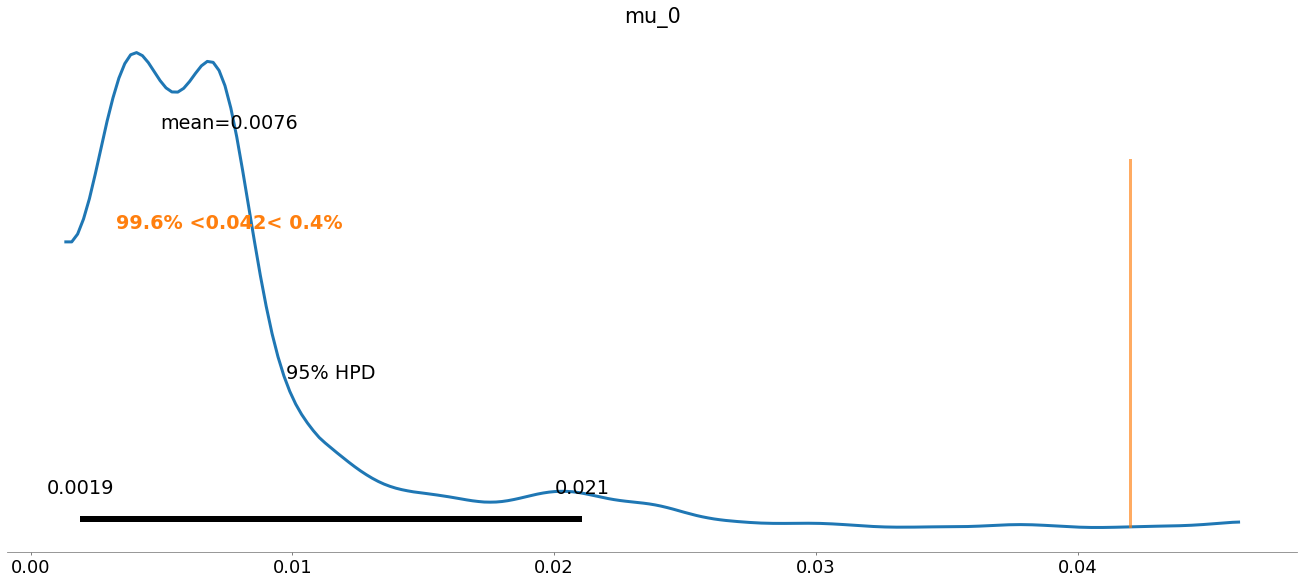

In [9]:
#collapse-hide

n_samp = len(trace['mu_0'])
mu0_summary = pm.summary(trace).loc['mu_0']
print("COVID-19 Global Mortality Rate Estimation:")
print("Posterior mean: %0.2f%%" % (100*trace['mu_0'].mean()))
print("Posterior median: %0.2f%%" % (100*np.median(trace['mu_0'])))
lower = np.sort(trace['mu_0'])[int(n_samp*0.025)]
upper = np.sort(trace['mu_0'])[int(n_samp*0.975)]
print("95%% posterior interval: (%0.2f%%, %0.2f%%)" % (100*lower, 100*upper))
prob_lt_reported = sum(trace['mu_0'] < reported_mortality_rate) / len(trace['mu_0'])
print("Probability true rate less than reported rate (%.2f%%) = %.2f%%" %
     (100*reported_mortality_rate, 100*prob_lt_reported))
print("")

# Posterior plot for mu0
print('Posterior probability density for COVID-19 mortality rate, controlling for country factors:')
ax = pm.plot_posterior(trace, var_names=['mu_0'], figsize=(18, 8), textsize=18,
                       credible_interval=0.95, bw=3.0, lw=3, kind='kde',
                       ref_val=round(reported_mortality_rate, 3))

## Magnitude and Significance of Factors 

For bias in reported COVID-19 mortality rate

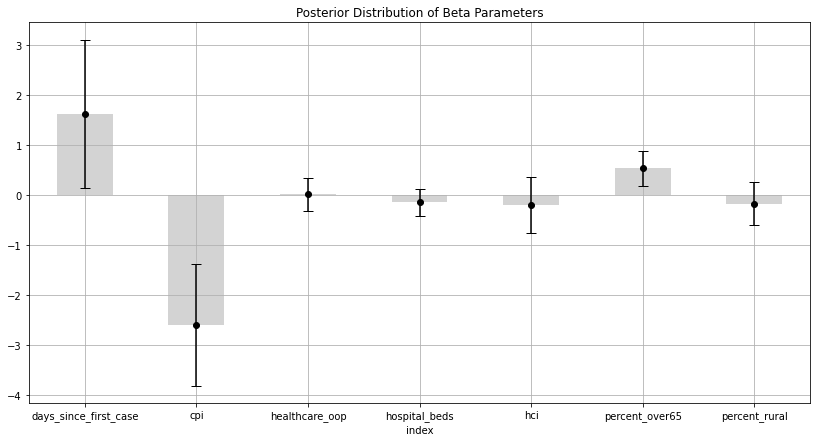

In [10]:
#collapse-hide

# Posterior summary for the beta parameters:
beta_summary = pm.summary(trace).head(7)
beta_summary.index = ['days_since_first_case', 'cpi', 'healthcare_oop', 'hospital_beds', 'hci', 'percent_over65', 'percent_rural']
beta_summary.reset_index(drop=False, inplace=True)

err_vals = ((beta_summary['hpd_3%'] - beta_summary['mean']).values,
            (beta_summary['hpd_97%'] - beta_summary['mean']).values)
ax = beta_summary.plot(x='index', y='mean', kind='bar', figsize=(14, 7),
                 title='Posterior Distribution of Beta Parameters',
                 yerr=err_vals, color='lightgrey',
                 legend=False, grid=True,
                 capsize=5)
beta_summary.plot(x='index', y='mean', color='k', marker='o', linestyle='None',
                  ax=ax, grid=True, legend=False, xlim=plt.gca().get_xlim())

plt.savefig('../images/corvid-mortality.png')

# About This Analysis

This analysis was done by [Joseph Richards](https://twitter.com/joeyrichar)

In this project[^3], we attempt to estimate the true mortality rate[^1] for COVID-19 while controlling for country-level covariates[^2][^4] such as:
* age of outbreak in the country
* transparency of the country's government
* access to healthcare
* demographics such as age of population and rural vs. urban

Estimating a mortality rate lower than the overall reported rate likely implies that there has been **significant under-testing and under-reporting of cases globally**.

## Interpretation of Country-Level Parameters 

1. days_since_first_case - positive (very statistically significant).  As time since outbreak increases, expected mortality rate **increases**, as expected.
2. cpi - negative (statistically significant).  As government transparency increases, expected mortality rate **decreases**.  This may mean that less transparent governments under-report cases, hence inflating the mortality rate.
3. healthcare avg. out-of-pocket spending - no significant trend.
4. hospital beds per capita - no significant trend.
5. Human Capital Index - no significant trend (slightly negative = mortality rates decrease with increased mobilization of the country)
6. percent over 65 - positive (statistically significant).  As population age increases, the mortality rate also **increases**, as expected.
7. percent rural - no significant trend.


[^1]: As of March 10, the **overall reported mortality rate is 3.5%**.  However, this figure does not account for **systematic biases in case reporting and testing**.  The observed mortality of COVID-19 has varied widely from country to country (as of early March 2020).  For instance, as of March 10, mortality rates have ranged from < 0.1% in places like Germany (1100+ cases) to upwards of 5% in Italy (9000+ cases) and 3.9% in China (80k+ cases).

[^2]: The point of our modelling work here is to **try to understand and correct for the country-to-country differences that may cause the observed discrepancies in COVID-19 country-wide mortality rates**.  That way we can "undo" those biases and try to **pin down an overall *real* mortality rate**.

[^3]: Full details about the model are available at:  https://github.com/jwrichar/COVID19-mortality

[^4]: The affects of these parameters are subject to change as more data are collected.
            

# Appendix: Model Diagnostics

The following trace plots help to assess the convergence of the MCMC sampler.

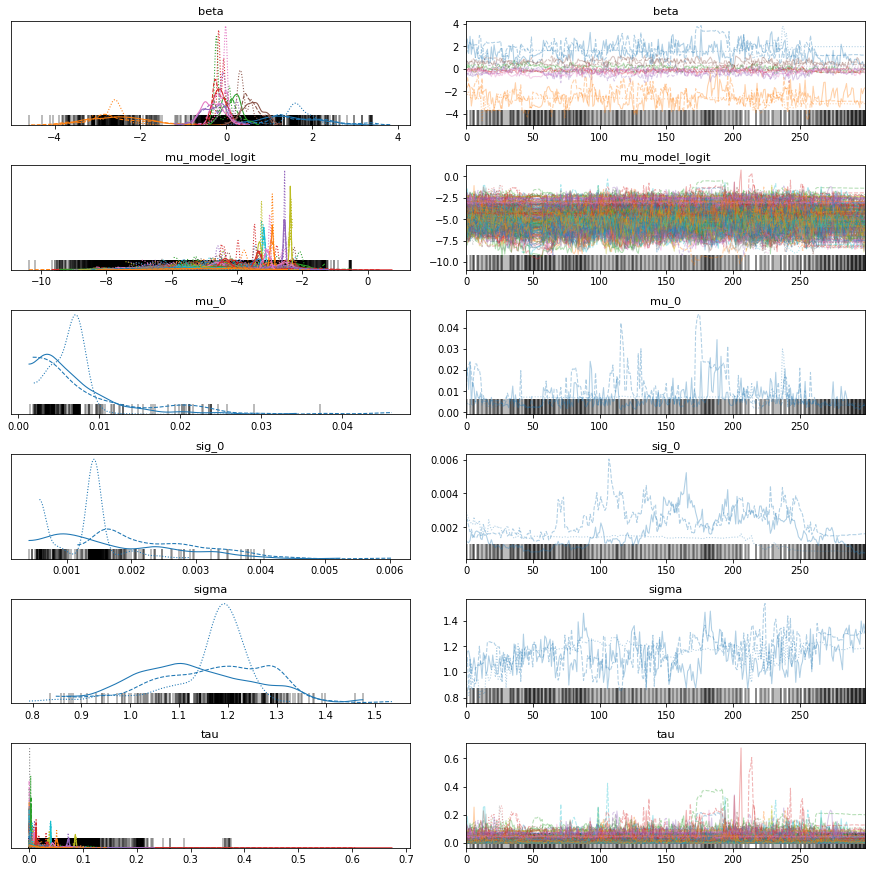

In [11]:
#hide_input
import arviz as az
az.plot_trace(trace, compact=True);